## KDS75 1973 Polynya Maude Rise wind isolation 2yr perturbation

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage




Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/mom01_unmasked_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/kds75.uvwt.230-257.ncra.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
#dzt = nc.variables['dzt'][:]
nc.close() # close the file
print st_ocean.shape
#print potrho.shape
print yt_ocean.shape

#fix this to a 12 month average
nc = Dataset('/g/data3/hh5/tmp/pas561/kds75_cp/dzt.9month.nc', mode='r') # file handle, open in read only mode
dzt = nc.variables['dzt'][:]
nc.close() # close the file
print dzt.shape

#fix this to a 12 month average
nc = Dataset('/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/output443/ocean.nc', mode='r') # file handle, open in read only mode
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print potrho.shape


dzt=np.squeeze(dzt)
print dzt.shape


(2700, 3600)
(2700, 3600)
(75,)
(2700,)
(1, 75, 2700, 3600)
(80,)
(75, 2700, 3600)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.2


In [4]:
NYFCntrlDir = '/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/'
NYFPertDir = '/g/data3/hh5/tmp/cosima/mom01v5/kds75_wp2/'


In [5]:
Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean.nc')
print Ocean_File
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl.temp.shape


Ocean_File = os.path.join(NYFPertDir,'output*/ocean.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.ty_trans_rho.shape

/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/output*/ocean.nc
(77, 75, 2700, 3600)
/g/data3/hh5/tmp/cosima/mom01v5/kds75_wp2/output*/ocean.nc
(78, 80, 2700, 3600)


In [6]:
#Note wind forcing goes for 3 years: output443 to output454
#Note that wind perturbation starts in April 1 instead of Jan 1. 
#output443 is April1 (same for control and perturbation) (missing first 3 momths of first year)


In [7]:
#plot wind stress
print cntrl.tau_x.shape
#cntrl_tx=ff.tau_x.load()
#cntrl_ty=ff.tau_y.load()

print pert.tau_x.shape
#pert_tx=ff.tau_x.load()
#pert_ty=ff.tau_y.load()
#print pert_tx.shape

(67, 2700, 3600)
(31, 2700, 3600)


(2700, 3600)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


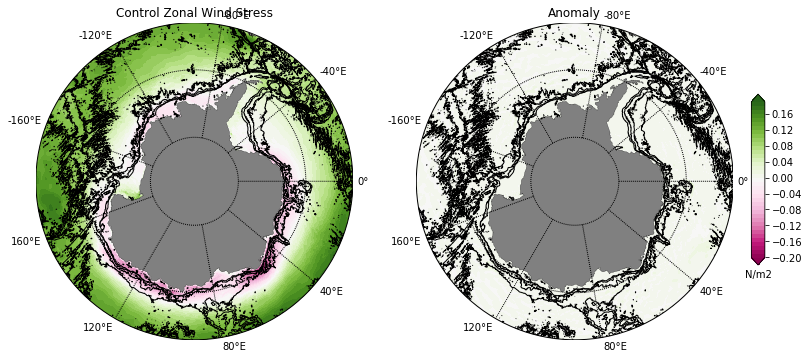

In [8]:
#do second full year
t1=3
t2=7

print pert.tau_x[0].shape

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('Wind Stress')

clev = np.arange(-.2,.2,.01)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl.tau_x[t1:t2,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Control Zonal Wind Stress')

#clev = np.arange(-.1,.1,.01)

plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert.tau_x[t1:t2,:,:].mean('time').load()-cntrl.tau_x[t1:t2,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Anomaly')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('N/m2')

#of = os.path.join(NYFPertDir,'tau_x.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'tau_x.png')
plt.savefig(of,dpi=220)


0 4 [443 444 445 446]
3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]


Text(0.5,0,u'N/m^2')

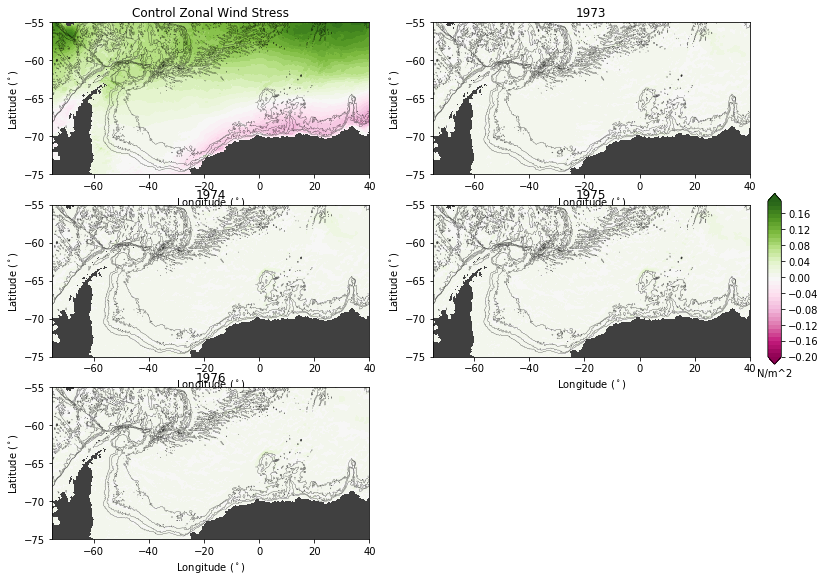

In [9]:
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-.2,.2,.01)
clev3 = np.arange(0,5000,1000)

t1=3
t2=7 

plt.subplot(321)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,cntrl.tau_x[t1:t2,:,:].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m^2')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-55))
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.xlim([-75,40])
plt.title('Control Zonal Wind Stress')


yrs=np.arange(1973,2016,1)

ii=0
seasons=np.arange(443,472)

for yr in range(0,4):
    
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
    
    print t1, t2, seasons[t1:t2]
    
    plt.subplot(3,2,yr+2)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(xt_ocean,yt_ocean,pert.tau_x[t1:t2,:,:].mean('time').load()-cntrl.tau_x[t1:t2,:,:].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('N/m^2')
    clev3 = np.arange(0,5000,1000)
    plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((-75,-55))
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.xlim([-75,40])
    plt.title(yrs[yr].astype('S4'))
    
    #ii+=12
    
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('N/m^2')

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)


In [8]:
#plot wind stress curl ... Ekman pumping anomalies.
#(d(Tau_y/f) /dx - d(Tau_x/f) / dy) /rho_0

#drhodx=np.gradient(rho[0,:,:,:],dxt,axis=2)
#print drhodx.shape
t1=0
t2=1

print cntrl.tau_x.shape
cntrl_Txf=cntrl.tau_x[t1:t2,:,:].mean('time').load()/fcor
cntrl_Tyf=cntrl.tau_y[t1:t2,:,:].mean('time').load()/fcor
print cntrl_Txf.shape

cntrl_dTyfdx=np.gradient(cntrl_Tyf,dxt,axis=1)
print cntrl_dTyfdx.shape
cntrl_dTxfdy=np.gradient(cntrl_Txf,dyt,axis=0)
print cntrl_dTxfdy.shape

rho0=1035.0
cntrl_we=(cntrl_dTyfdx-cntrl_dTxfdy)/rho0


print pert.tau_x.shape
pert_Txf=pert.tau_x[t1:t2,:,:].mean('time').load()/fcor
pert_Tyf=pert.tau_y[t1:t2,:,:].mean('time').load()/fcor
print pert_Tyf.shape

pert_dTyfdx=np.gradient(pert_Tyf,dxt,axis=1)
print pert_dTyfdx.shape
pert_dTxfdy=np.gradient(pert_Txf,dyt,axis=0)
print pert_dTxfdy.shape

rho0=1035.0
pert_we=(pert_dTyfdx-pert_dTxfdy)/rho0



(48, 2700, 3600)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(2700, 3600)
(2700, 3600)
(2700, 3600)
(29, 2700, 3600)
(2700, 3600)
(2700, 3600)
(2700, 3600)


In [33]:
m=np.nanmax(cntrl_we[0:1000,:])
print m
m=np.nanmin(cntrl_we[0:1000,:])
print m

m=np.nanmax(pert_we[0:1000,:])
print m
m=np.nanmin(pert_we[0:1000,:])
print m

#convert from m/s to m/day
s_day=60*60*24
print s_day
cntrl_we=cntrl_we*s_day
pert_we=pert_we*s_day

m=np.nanmax(cntrl_we[0:1000,:])
print m
m=np.nanmin(cntrl_we[0:1000,:])
print m

m=np.nanmax(pert_we[0:1000,:])
print m
m=np.nanmin(pert_we[0:1000,:])
print m


0.000179934556938
-0.000175000078233
0.000179779283047
-0.000176330384025
86400
15.5463457194
-15.1200067593
15.5329300553
-15.2349451798


In [34]:
print cntrl_we.shape

(2700, 3600)


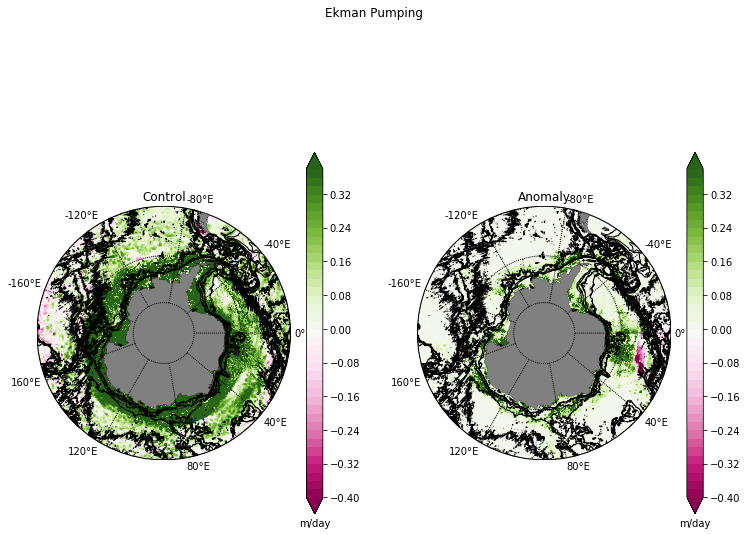

In [35]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Ekman Pumping')
clev = np.arange(-.4,.4,.02)

plt.subplot(1,2,1)
map = Basemap(projection='spstere',boundinglat=-50,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl_we, cmap=plt.cm.PiYG, levels=clev,extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m/day')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Control')


plt.subplot(1,2,2)
map = Basemap(projection='spstere',boundinglat=-50,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert_we-cntrl_we, cmap=plt.cm.PiYG, levels=clev,extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m/day')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('Anomaly')


#of = os.path.join(NYFPertDir,'we.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'we.png')
plt.savefig(of,dpi=220)


In [6]:
#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'output443/ice_month.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print cntrl_i.CN[0:4,:,0:1000,:].shape
print cntrl_i.CN[:,:,0:1000,:].sum('ct').shape

(3, 1000, 3600)


In [7]:
#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFPertDir,'output443/ice_month.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert_i.CN[:,:,0:1000,:].sum('ct').shape

(3, 1000, 3600)


In [23]:
#plot stamps of sea ice concentration.
#Ocean_File = os.path.join(NYFCntrlDir,'output4*/ice_month.nc')
#cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)

#Ocean_File = os.path.join(NYFPertDir,'output4*/ice_month.nc')
#pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)

In [32]:
#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'CN.cat.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl_i.CN.shape

Ocean_File = os.path.join(NYFPertDir,'CN.cat.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert_i.CN.shape

(144, 5, 2700, 3600)
(121, 5, 2700, 3600)


In [13]:
mnths=np.arange(0,6*12)
tits1=['Apr','May','June','July','Aug.','Sept.','Oct.', 'Nov.']
tits2=['Jan','Feb','Mar','Apr','May','June','July','Aug.','Sept.','Oct.', 'Nov.', 'Sep.','Oct.','Nov.','Dec.']
#print mnths
for yr in range(0,11):
    for i in range(5,11):    
        if yr==0:
            t1=i-3
            print t1, mnths[t1], tits1[t1]
        elif yr==1:
            t1=i-3
            print t1, mnths[t1], tits1[t1]
        else:
            t1=(yr-1)*12+i-3
            print t1, mnths[t1]#, tits2[t1]
        
#14,26,38 .... is june

2 2 June
3 3 July
4 4 Aug.
5 5 Sept.
6 6 Oct.
7 7 Nov.
2 2 June
3 3 July
4 4 Aug.
5 5 Sept.
6 6 Oct.
7 7 Nov.
14 14
15 15
16 16
17 17
18 18
19 19
26 26
27 27
28 28
29 29
30 30
31 31
38 38
39 39
40 40
41 41
42 42
43 43
50 50
51 51
52 52
53 53
54 54
55 55


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
2
3
4
5
6
7
2
3
4
5
6
7
14
15
16
17
18
19
26
27
28
29
30
31
38
39
40
41
42
43
50
51
52
53
54
55
62
63
64
65
66
67
74
75
76
77
78
79
86
87
88
89
90
91
98
99
100
101
102
103


ValueError: num must be 1 <= num <= 60, not 61

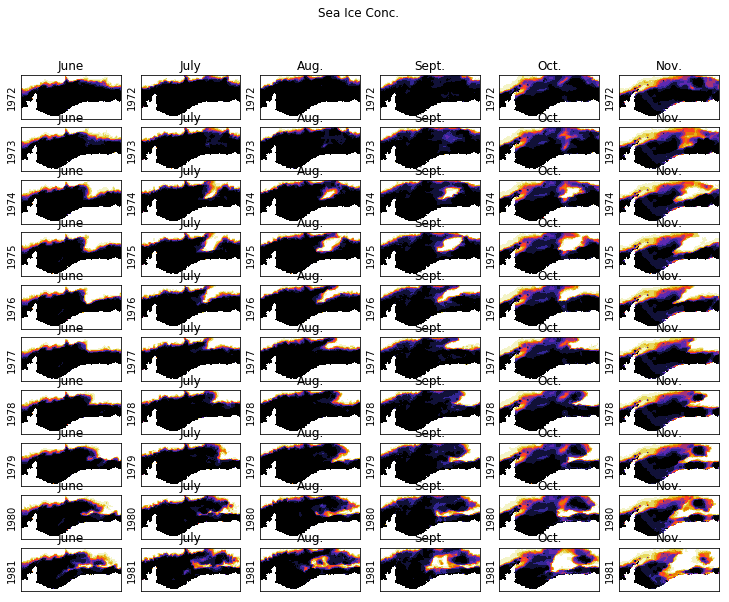

In [33]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Sea Ice Conc.')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print tits


ii=0
for yr in range(0,11):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(10,6,ii+1)
        plt.gca().patch.set_color('.25')
        
        if yr==0:
            #starts in april 
            t1=i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],cntrl_i.CN[t1,:,0:1000,:].sum('ct').load(),cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
        elif yr==1:
            #starts in april 
            t1=i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],pert_i.CN[t1,:,0:1000,:].sum('ct').load(),cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
        else:
            t1=(yr-1)*12+i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],pert_i.CN[t1,:,0:1000,:].sum('ct').load(),cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
        
        print t1
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        plt.ylabel(yrs[yr])
        plt.xlim([-80,40])
        plt.title(tits[i-5])     
        plt.gca().axes.get_xaxis().set_ticks([])
        plt.gca().axes.get_yaxis().set_ticks([])
        
        ii+=1

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'cn.png')
plt.savefig(of,dpi=220)


In [1]:
Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean.nc')
print Ocean_File
cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl.mld.shape

Ocean_File = os.path.join(NYFPertDir,'output*/ocean.nc')
print Ocean_File
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert.mld.shape

NameError: name 'os' is not defined

In [6]:
print cntrl.mld.shape
print pert.mld.shape

(67, 2700, 3600)
(40, 2700, 3600)


In [8]:
t1=3
t2=27
seasons=np.arange(443,500)
print seasons[t1:t2]
#446 to 469 is 6 full years

[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469]


[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


0 4 [443 444 445 446]
3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]
15 19 [458 459 460 461]
19 23 [462 463 464 465]
23 27 [466 467 468 469]
27 31 [470 471 472 473]
31 35 [474 475 476 477]
35 39 [478 479 480 481]
39 43 [482 483 484 485]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


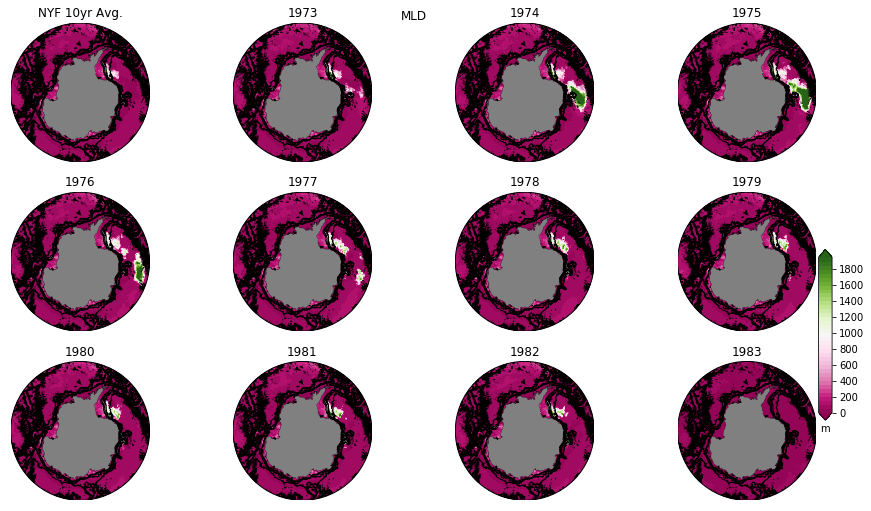

In [9]:
#plot MLD
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('MLD')
clev = np.arange(0,2000,50)
yrs=np.arange(1972,2018,1)

t1=3
t2=27
print seasons[t1:t2]

plt.subplot(4,4,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
#map.drawparallels(np.arange(-80.,81.,15.))
#map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl.mld[t1:t2].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('N/m2')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('NYF 10yr Avg.')

ii=0

for yr in range(0,11):
    
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
    
        
    print t1, t2, seasons[t1:t2]

    plt.subplot(4,4,yr+2)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    #map.drawparallels(np.arange(-80.,81.,15.))
    #map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,pert.mld[t1:t2,:,:].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr+1])

ax3 = plt.axes([0.95,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('m')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'mld.png')
plt.savefig(of,dpi=220)


/g/data3/hh5/tmp/cosima/mom01v5/kds75_wp2/
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469]
[446 447 448 449 450 451 452 453 454 455 456 457]


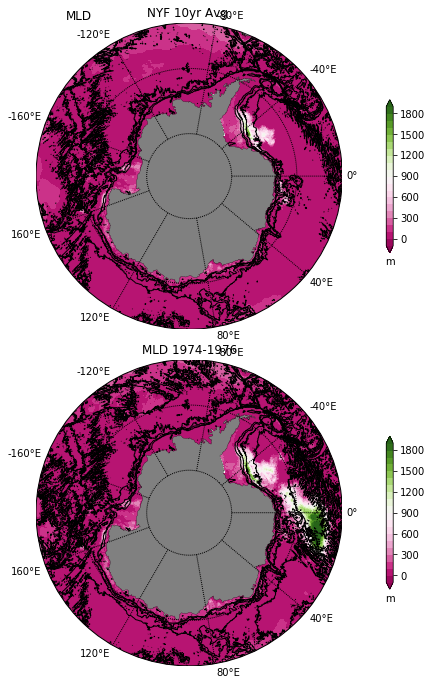

In [10]:
print NYFPertDir

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('MLD')

t1=3
t2=27
#446 to 469 is 6 full years
print seasons[t1:t2]

clev = np.arange(-100,2000,100)
plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,cntrl.mld[t1:t2].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('m')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('NYF 10yr Avg.')

t1=3
t2=15
print seasons[t1:t2]

plt.subplot(2,1,2)
map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,pert.mld[t1:t2].mean('time').load(), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('m')
clev3 = np.arange(1000,5001,1000)
map.contour(X,Y,ht,levels=clev3,colors='k',linewidths=1)
plt.title('MLD 1974-1976')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'mld_1975anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'mld_1974-76.png')
plt.savefig(of,dpi=220)

In [11]:
t1=3
t2=15
print seasons[t1:t2]

t1=3
t2=27
seasons=np.arange(443,520)
print seasons.shape


[446 447 448 449 450 451 452 453 454 455 456 457]
(57,)


In [12]:
print pert.ty_trans_rho.shape

(40, 80, 2700, 3600)


## Calc the GMOC from ty_trans_rho 

In [21]:
print pert.ty_trans_rho.shape[0]

pert_gmoc=np.zeros((pert.ty_trans_rho.shape[0],pert.ty_trans_rho.shape[1],pert.ty_trans_rho.shape[2]))
print pert_gmoc.shape

for t in range(pert.ty_trans.shape[0]):
    print t
    pert_gmoc[t,:,:]=pert.ty_trans_rho[t,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print pert_gmoc.shape

of=os.path.join(NYFPertDir,'gmoc_adv_rho.npy')
a=np.save(of,pert_gmoc)

78
(78, 80, 2700)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
(78, 80, 2700)


In [6]:
Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean.nc')
print cntrl.ty_trans_rho.shape

cntrl_gmoc=np.zeros((cntrl.ty_trans_rho.shape[0],cntrl.ty_trans_rho.shape[1],cntrl.ty_trans_rho.shape[2]))
print cntrl_gmoc.shape

for t in range(cntrl.ty_trans.shape[0]):
    print t
    cntrl_gmoc[t,:,:]=cntrl.ty_trans_rho[t,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print cntrl_gmoc.shape

of=os.path.join(NYFCntrlDir,'gmoc_adv_rho.npy')
a=np.save(of,cntrl_gmoc)

(77, 80, 2700, 3600)
(77, 80, 2700)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
(77, 80, 2700)


In [8]:
#t1=3
#t2=27
#seasons=np.arange(443,472)
#print seasons[t1:t2]

#print cntrl.ty_trans_rho.shape
#cntrl_gmoc=cntrl.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
#print cntrl_gmoc.shape

#of=os.path.join(NYFCntrlDir,'gmoc_adv_rho.npy')
#a=np.save(of,cntrl_gmoc)


In [8]:
#load gmoc in rho space
of=os.path.join(NYFPertDir,'gmoc_adv_rho.npy')
pert_gmoc=np.load(of)
print pert_gmoc.shape

#of=os.path.join(NYFCntrlDir,'cntrl_gmocs.npy')
of=os.path.join(NYFCntrlDir,'gmoc_adv_rho.npy')
cntrl_gmoc=np.load(of)
print cntrl_gmoc.shape

(78, 80, 2700)
(77, 80, 2700)


In [9]:
#yrs=np.arange(1973,2016,1)
#print yrs
#print yrs.astype('S4')

yrs=np.arange(1973,2016,1)

ii=0
seasons=np.arange(443,520)

for yr in range(0,19):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
        
    print t1, t2, seasons[t1:t2]
      

0 4 [443 444 445 446]
3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]
15 19 [458 459 460 461]
19 23 [462 463 464 465]
23 27 [466 467 468 469]
27 31 [470 471 472 473]
31 35 [474 475 476 477]
35 39 [478 479 480 481]
39 43 [482 483 484 485]
43 47 [486 487 488 489]
47 51 [490 491 492 493]
51 55 [494 495 496 497]
55 59 [498 499 500 501]
59 63 [502 503 504 505]
63 67 [506 507 508 509]
67 71 [510 511 512 513]
71 75 [514 515 516 517]


3 27 [446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469]
0 4 [443 444 445 446]
3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]
15 19 [458 459 460 461]
19 23 [462 463 464 465]
23 27 [466 467 468 469]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


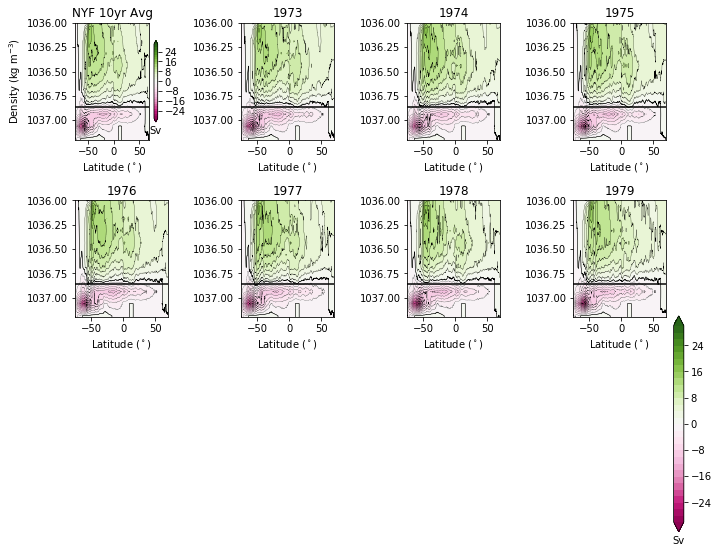

In [10]:
seasons=np.arange(443,472)
t1=3
t2=27
print t1, t2, seasons[t1:t2]

#plot gmoc adv in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('Advective GMOC')
clev = np.arange(-30,32,2)


plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,70])
tit='NYF 10yr Avg'
plt.title(tit)
plt.plot([-75,70], [1036.86,1036.86], 'k')


ii=0
for yr in range(0,7):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
        
    print t1, t2, seasons[t1:t2]

    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036))
    #plt.ylabel('Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,70])
    tit=yrs[yr].astype('S4')
    plt.title(yrs[yr])
    plt.plot([-75,70], [1036.86,1036.86], 'k')


ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_adv.png')
plt.savefig(of,dpi=220)

3 27 [446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469]


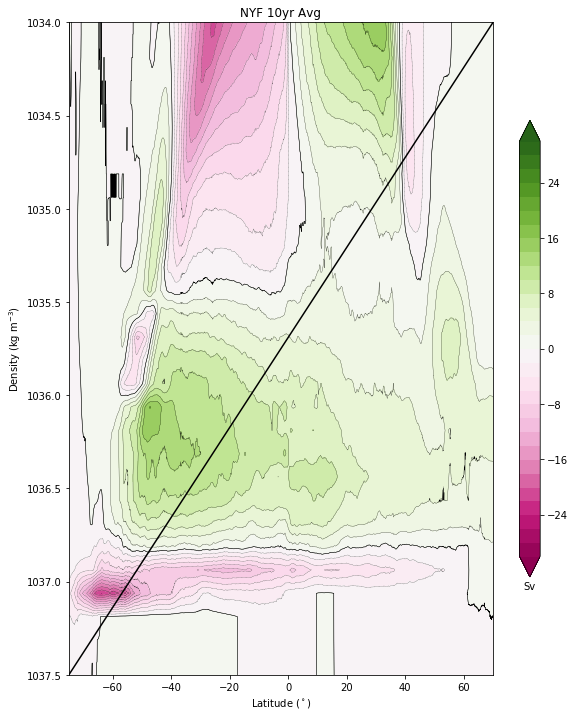

In [12]:
seasons=np.arange(443,472)
t1=3
t2=27
print t1, t2, seasons[t1:t2]

#plot gmoc adv in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('Advective GMOC')
clev = np.arange(-30,32,2)


#plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1034.0))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,70])
tit='NYF 10yr Avg'
plt.title(tit)
plt.plot([-75,70], [1037.5,1034.0], 'k')

3 27 [446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469]
[443 444 445 446]
[446 447 448 449]
[450 451 452 453]
[454 455 456 457]
[458 459 460 461]
[462 463 464 465]
[466 467 468 469]


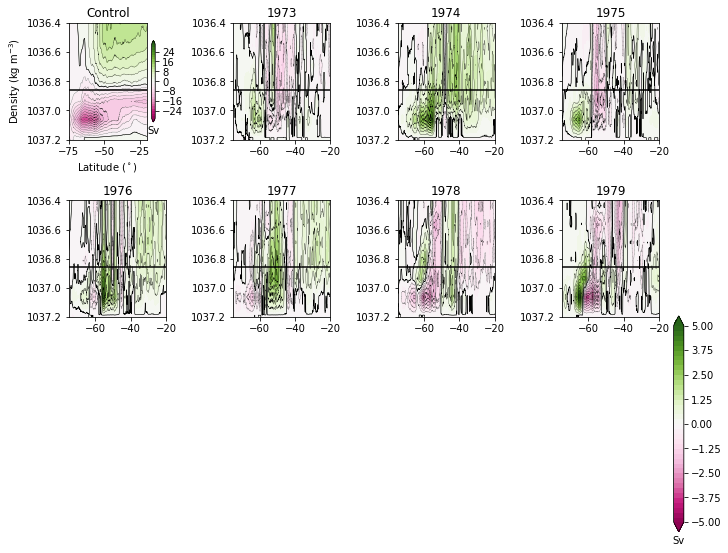

In [33]:
seasons=np.arange(443,499)
#first year is only 9 months ... use first 3 months of next year
t1a=3
t2a=27
print t1a, t2a, seasons[t1a:t2a]


#plot gmoc anom in rho space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('GMOC Adv Anomaly')

clev = np.arange(-30,32,2)

plt.subplot(541)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1a:t2a,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1a:t2a,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1a:t2a,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.2,1036.4))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-75,-20])
tit='Control'
plt.title(tit)
plt.plot([-75,-20], [1036.86,1036.86], 'k')

yrs=np.arange(1973,2016,1)

ii=0

clev = np.arange(-5,5.25,0.25)

clev2 = np.arange(-10,11,1)


for yr in range(0,7):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
    
    print seasons[t1:t2]
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    p1=plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev2,colors='k',linewidths=0.25)
    plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.2,1036.4))
    #plt.ylabel('Density (kg m$^{-3}$)')
    #plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-75,-20])
    tit='Anom. ' + yrs[yr].astype('S4')
    plt.title(yrs[yr].astype('S4'))
    plt.plot([-75,-20], [1036.86,1036.86], 'k')

    
ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc_anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_adv_anom.png')
plt.savefig(of,dpi=220)

In [10]:
#store annual mean gmoc (instead of seasonal)
pert_gmoc_ann=np.zeros((19,pert.ty_trans_rho.shape[1],pert.ty_trans_rho.shape[2]))
cntrl_gmoc_ann=np.zeros((19,pert.ty_trans_rho.shape[1],pert.ty_trans_rho.shape[2]))

for yr in range(0,19):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
    
    print seasons[t1:t2]
    
    pert_gmoc_ann[yr,:,:]=np.mean(pert_gmoc[t1:t2,:,:],axis=0)
    cntrl_gmoc_ann[yr,:,:]=np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)

[443 444 445 446]
[446 447 448 449]
[450 451 452 453]
[454 455 456 457]
[458 459 460 461]
[462 463 464 465]
[466 467 468 469]
[470 471 472 473]
[474 475 476 477]
[478 479 480 481]
[482 483 484 485]
[486 487 488 489]
[490 491 492 493]
[494 495 496 497]
[498 499 500 501]
[502 503 504 505]
[506 507 508 509]
[510 511 512 513]
[514 515 516 517]


(50,)
19 1992
(19,)
(19,)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/ipykernel/__main__.py:

(20,) (20,)
here (19,) 19


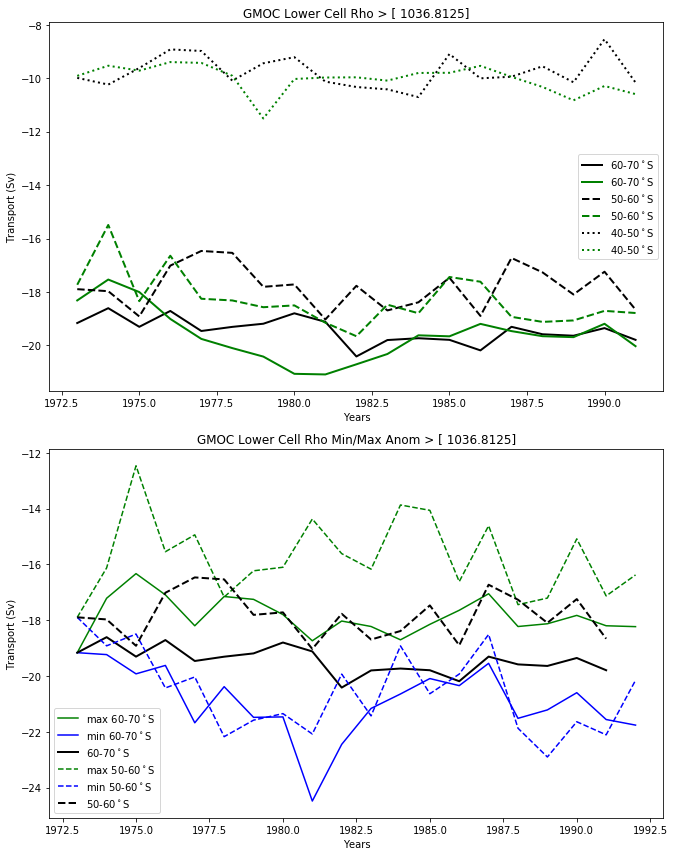

In [11]:
#plot time series of AABW or full transports 
T=np.arange(50)
print T.shape


z1=np.argwhere(potrho<1036.86)
z1=z1[-1]

ts=pert_gmoc_ann.shape
ts=ts[0]
yrs=np.arange(1973,2018,1)
print ts,yrs[ts]

# do lower cell average between lats 60-65S
j1=np.argwhere(yt_ocean<-69.9)
j2=np.argwhere(yt_ocean<-60)
j1=j1[-1]
j2=j2[-1]

lc_cntrl60_psj = cntrl_gmoc_ann[0:ts,z1:,j1:j2]
lc_cntrl60_psj_bar = np.mean(lc_cntrl60_psj,2)
lc_cntrl60_psj_ts = np.min(lc_cntrl60_psj_bar,1)
print lc_cntrl60_psj_ts.shape

lc_pert60_psj = pert_gmoc_ann[:,z1:,j1:j2]
lc_pert60_psj_bar = np.mean(lc_pert60_psj,2)
lc_pert60_psj_ts = np.min(lc_pert60_psj_bar,1)
print lc_pert60_psj_ts.shape

lc_anom60_psj = pert_gmoc_ann[0:ts,z1:,j1:j2]-cntrl_gmoc_ann[0:ts,z1:,j1:j2]
lc_max_anom60_psj_ts = np.max(lc_anom60_psj,1)
lc_max_anom60_psj_ts = np.max(lc_max_anom60_psj_ts,1)
lc_max_anom60_psj_ts=np.insert(lc_max_anom60_psj_ts,0,0)
lc_max60_ts = lc_max_anom60_psj_ts + lc_cntrl60_psj_ts[0]

lc_min_anom60_psj_ts = np.min(lc_anom60_psj,1)
lc_min_anom60_psj_ts = np.min(lc_min_anom60_psj_ts,1)
lc_min_anom60_psj_ts=np.insert(lc_min_anom60_psj_ts,0,0)
lc_min60_ts = lc_min_anom60_psj_ts + lc_cntrl60_psj_ts[0]

#print lc_max_ts
#print lc_min_ts

# do lower cell average between lats 40-45S
j1=np.argwhere(yt_ocean<-49.9)
j2=np.argwhere(yt_ocean<-40)
j1=j1[-1]
j2=j2[-1]

lc_cntrl40_psj = cntrl_gmoc_ann[0:ts,z1:,j1:j2]
lc_cntrl40_psj_bar = np.mean(lc_cntrl40_psj,2)
lc_cntrl40_psj_ts = np.min(lc_cntrl40_psj_bar,1)

lc_pert40_psj = pert_gmoc_ann[:,z1:,j1:j2]
lc_pert40_psj_bar = np.mean(lc_pert40_psj,2)
lc_pert40_psj_ts = np.min(lc_pert40_psj_bar,1)

lc_anom40_psj = pert_gmoc_ann[0:ts,z1:,j1:j2]-cntrl_gmoc_ann[0:ts,z1:,j1:j2]

lc_max_anom40_psj_ts = np.max(lc_anom40_psj,1)
lc_max_anom40_psj_ts = np.max(lc_max_anom40_psj_ts,1)
lc_max_anom40_psj_ts=np.insert(lc_max_anom40_psj_ts,0,0)
lc_max40_ts = lc_max_anom40_psj_ts + lc_cntrl40_psj_ts[0]

lc_min_anom40_psj_ts = np.min(lc_anom40_psj,1)
lc_min_anom40_psj_ts = np.min(lc_min_anom40_psj_ts,1)
lc_min_anom40_psj_ts=np.insert(lc_min_anom40_psj_ts,0,0)
lc_min40_ts = lc_min_anom40_psj_ts + lc_cntrl40_psj_ts[0]

# do lower cell average between lats 20-25S
j1=np.argwhere(yt_ocean<-59.9)
j2=np.argwhere(yt_ocean<-50)
j1=j1[-1]
j2=j2[-1]

lc_cntrl50_psj = cntrl_gmoc_ann[0:ts,z1:,j1:j2]
lc_cntrl50_psj_bar = np.mean(lc_cntrl50_psj,2)
lc_cntrl50_psj_ts = np.min(lc_cntrl50_psj_bar,1)

lc_pert50_psj = pert_gmoc_ann[:,z1:,j1:j2]
lc_pert50_psj_bar = np.mean(lc_pert50_psj,2)
lc_pert50_psj_ts = np.min(lc_pert50_psj_bar,1)

lc_anom50_psj = pert_gmoc_ann[0:ts,z1:,j1:j2]-cntrl_gmoc_ann[0:ts,z1:,j1:j2]


lc_max_anom50_psj_ts = np.max(lc_anom50_psj,1)
lc_max_anom50_psj_ts = np.max(lc_max_anom50_psj_ts,1)
lc_max_anom50_psj_ts=np.insert(lc_max_anom50_psj_ts,0,0)
lc_max50_ts = lc_max_anom50_psj_ts + lc_cntrl50_psj_ts[0]

lc_min_anom50_psj_ts = np.min(lc_anom50_psj,1)
lc_min_anom50_psj_ts = np.min(lc_min_anom50_psj_ts,1)
lc_min_anom50_psj_ts=np.insert(lc_min_anom50_psj_ts,0,0)
lc_min50_ts = lc_min_anom50_psj_ts + lc_cntrl50_psj_ts[0]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

plt.subplot(211)
plt.plot(yrs[0:ts],lc_cntrl60_psj_ts,linestyle='-',color='k',label='60-70$^\circ$S',linewidth=2)
plt.plot(yrs[0:ts],lc_pert60_psj_ts,linestyle='-',color='g',label='60-70$^\circ$S',linewidth=2)
plt.plot(yrs[0:ts],lc_cntrl50_psj_ts,linestyle='--',color='k',label='50-60$^\circ$S',linewidth=2)
plt.plot(yrs[0:ts],lc_pert50_psj_ts,linestyle='--',color='g',label='50-60$^\circ$S',linewidth=2)
plt.plot(yrs[0:ts],lc_cntrl40_psj_ts,linestyle=':',color='k',label='40-50$^\circ$S',linewidth=2)
plt.plot(yrs[0:ts],lc_pert40_psj_ts,linestyle=':',color='g',label='40-50$^\circ$S',linewidth=2)
#plt.plot(lc_max40_ts,linestyle=':',color='g',linewidth=1.5)
#plt.plot(lc_min40_ts,linestyle=':',color='b',linewidth=1.5)
#plt.plot(lc_cntrl40_psj_ts,linestyle=':',color='k',label='40-50$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Lower Cell Rho > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)

print lc_max60_ts.shape,lc_min60_ts.shape
print 'here', lc_cntrl60_psj_ts.shape, ts

ts=lc_max60_ts.shape[0]
plt.subplot(212)
plt.plot(yrs[0:ts],lc_max60_ts,linestyle='-',color='g',label='max 60-70$^\circ$S',linewidth=1.5)
plt.plot(yrs[0:ts],lc_min60_ts,linestyle='-',color='b',label='min 60-70$^\circ$S',linewidth=1.5)
plt.plot(yrs[0:ts-1],lc_cntrl60_psj_ts,linestyle='-',color='k',label='60-70$^\circ$S',linewidth=2)
plt.plot(yrs[0:ts],lc_max50_ts,linestyle='--',label='max 50-60$^\circ$S',color='g',linewidth=1.5)
plt.plot(yrs[0:ts],lc_min50_ts,linestyle='--',label='min 50-60$^\circ$S',color='b',linewidth=1.5)
plt.plot(yrs[0:ts-1],lc_cntrl50_psj_ts,linestyle='--',color='k',label='50-60$^\circ$S',linewidth=2)
#plt.plot(lc_max40_ts,linestyle=':',color='g',linewidth=1.5)
#plt.plot(lc_min40_ts,linestyle=':',color='b',linewidth=1.5)
#plt.plot(lc_cntrl40_psj_ts,linestyle=':',color='k',label='40-50$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Lower Cell Rho Min/Max Anom > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)


plt.tight_layout()

#of = os.path.join(NYFPertDir,'gmoc_ts.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'gmoc_ts.png')
plt.savefig(of,dpi=220)

In [ ]:
#calc tx transport, acc transport
cntrl_psi=cntrl.tx_trans[:,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()
print cntrl_psi.shape

of=os.path.join(NYFCntrlDir,'psi.npy')
a=np.save(of,cntrl_psi)


In [ ]:
#calc tx transport, acc transport
pert_psi=pert.tx_trans[:,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()
print pert_psi.shape

of=os.path.join(NYFPertDir,'psi.npy')
a=np.save(of,pert_psi)



In [12]:
#Ocean_File = os.path.join(NYFCntrlDir,'output4*/ocean.nc')
print cntrl.tx_trans.shape

cntrl_psi=np.zeros((cntrl.tx_trans.shape[0],cntrl.tx_trans.shape[2],cntrl.tx_trans.shape[3]))
print cntrl_psi.shape

for t in range(cntrl.tx_trans.shape[0]):
    print t
    cntrl_psi[t,:,:]=cntrl.tx_trans[t,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()

print cntrl_psi.shape

of=os.path.join(NYFCntrlDir,'psi.npy')
a=np.save(of,cntrl_psi)


(77, 75, 2700, 3600)
(77, 2700, 3600)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
(77, 2700, 3600)


In [6]:
#Ocean_File = os.path.join(NYFCntrlDir,'output4*/ocean.nc')
print pert.tx_trans.shape

pert_psi=np.zeros((pert.tx_trans.shape[0],pert.tx_trans.shape[2],pert.tx_trans.shape[3]))
print pert_psi.shape

for t in range(pert.tx_trans.shape[0]):
    print t
    pert_psi[t,:,:]=pert.tx_trans[t,:,:,:].sum('st_ocean').cumsum('yt_ocean').load()

print pert_psi.shape

of=os.path.join(NYFPertDir,'psi.npy')
a=np.save(of,pert_psi)


(78, 75, 2700, 3600)
(78, 2700, 3600)
0
1


KeyboardInterrupt: 

In [64]:
#load acc psi
of=os.path.join(NYFPertDir,'psi.npy')
pert_psi=np.load(of)
print pert_psi.shape

#of=os.path.join(NYFCntrlDir,'cntrl_gmocs.npy')
of=os.path.join(NYFCntrlDir,'psi.npy')
cntrl_psi=np.load(of)
print cntrl_psi.shape

(29, 2700, 3600)
(30, 2700, 3600)


[-160 -155 -150 -145 -140 -135 -130 -125 -120 -115 -110 -105 -100  -95  -90
  -85  -80  -75  -70  -65  -60  -55  -50  -45  -40  -35  -30  -25  -20  -15
  -10   -5    0    5   10   15   20   25   30   35   40   45   50   55   60
   65   70   75   80   85   90   95  100  105  110  115  120  125  130  135
  140  145  150  155]


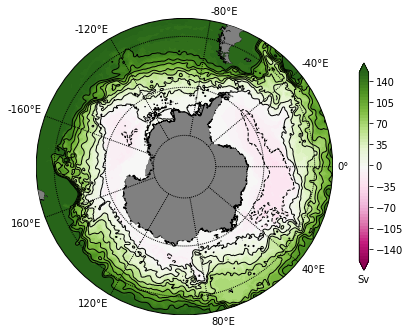

In [65]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plot ACC transport

clev = np.arange(-160,160,5)
print clev

clev2 = np.arange(-160,160,20)
#print clev2

plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(cntrl_psi[0:4],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
map.contour(X,Y,np.mean(cntrl_psi[0:4],axis=0),levels=clev2,colors='k',linewidths=1)


In [ ]:
#store annual mean psi (instead of seasonal)
pert_psi_ann=np.zeros((19,pert.tx_trans.shape[2],pert.tx_trans.shape[3]))
cntrl_psi_ann=np.zeros((19,pert.tx_trans.shape[2],pert.tx_trans.shape[3]))

for yr in range(0,19):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
    
    print seasons[t1:t2]
    
    pert_psi_ann[yr,:,:]=np.mean(pert_psi[t1:t2,:,:],axis=0)
    cntrl_psi_ann[yr,:,:]=np.mean(cntrl_psi[t1:t2,:,:],axis=0)

[-200 -195 -190 -185 -180 -175 -170 -165 -160 -155 -150 -145 -140 -135 -130
 -125 -120 -115 -110 -105 -100  -95  -90  -85  -80  -75  -70  -65  -60  -55
  -50  -45  -40  -35  -30  -25  -20  -15  -10   -5    0    5   10   15   20
   25   30   35   40   45   50   55   60   65   70   75   80   85   90   95
  100  105  110  115  120  125  130  135  140  145  150  155  160  165  170
  175  180  185  190  195]
[1000 2000 3000 4000 5000]


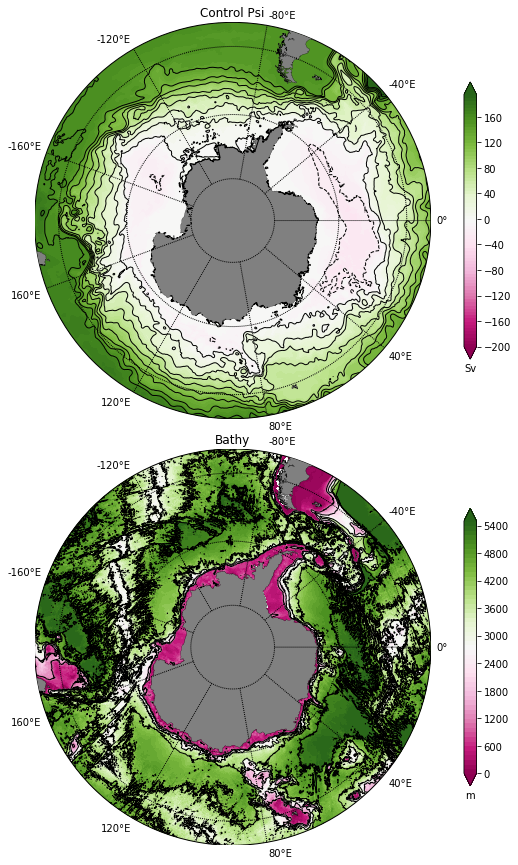

In [69]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plot ACC transport

t1=3
t2=27

clev = np.arange(-200,200,5)
print clev

clev2 = np.arange(-200,200,20)
#print clev2

plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(cntrl_psi_ann[0:7],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
map.contour(X,Y,np.mean(cntrl_psi_ann[0:7],axis=0),levels=clev2,colors='k',linewidths=1)

#clev3 = np.arange(1000,5001,1000)
#print clev3
#map.contour(X,Y,ht[:,:],levels=clev3,colors='c',linewidths=1)    

plt.title('Control Psi')

plt.subplot(2,1,2)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
clev3 = np.arange(0,5600,100)
p1=map.contourf(X,Y,ht[:,:], cmap=plt.cm.PiYG, levels=clev3, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('m')
#clev3 = np.arange(0,200,20)
#print clev3

clev3 = np.arange(1000,5001,1000)
print clev3
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    
plt.title('Bathy')

plt.tight_layout()


[-160 -155 -150 -145 -140 -135 -130 -125 -120 -115 -110 -105 -100  -95  -90
  -85  -80  -75  -70  -65  -60  -55  -50  -45  -40  -35  -30  -25  -20  -15
  -10   -5    0    5   10   15   20   25   30   35   40   45   50   55   60
   65   70   75   80   85   90   95  100  105  110  115  120  125  130  135
  140  145  150  155]


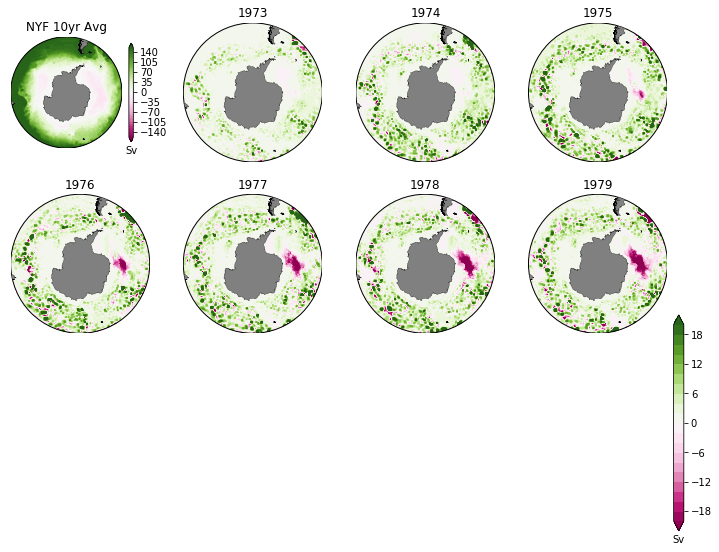

In [70]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('Psi Anom')
#plot ACC transport
yrs=np.arange(1973,2016,1)

ii=0
clev = np.arange(-160,160,5)
print clev

t1=3
t2=27

plt.subplot(5,4,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
#map.drawparallels(np.arange(-80.,81.,15.))
#map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(cntrl_psi_ann[t1:t2,:,:],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
#map.contour(X,Y,np.mean(cntrl_psi[0:5],axis=0),levels=clev,colors='k',linewidths=1)    
#tit=yrs[yr].astype('S4')
plt.title('NYF 10yr Avg')
    
clev = np.linspace(-20,20,21)

for yr in range(0,7):
    
    #np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0)
    plt.subplot(5,4,yr+2)
    map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    #map.drawparallels(np.arange(-80.,81.,15.))
    #map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,pert_psi_ann[yr,:,:]-cntrl_psi_ann[yr,:,:], cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('Sv')
    #clev3 = np.arange(0,200,20)
    #print clev3
    #map.contour(X,Y,np.mean(cntrl_psi[0:5],axis=0),levels=clev,colors='k',linewidths=1)
    
    tit=yrs[yr].astype('S4')
    plt.title(tit)
    
    
ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Sv')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'wpm2_cn.pdf')
#print of
#plt.savefig(of)
#of = os.path.join(NYFPertDir,'wpm2_cn.png')
#plt.savefig(of,dpi=220)
#of = os.path.join(NYFPertDir,'gmoc_anom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'psi_anom.png')
plt.savefig(of,dpi=220)

[1000 2000 3000 4000 5000]


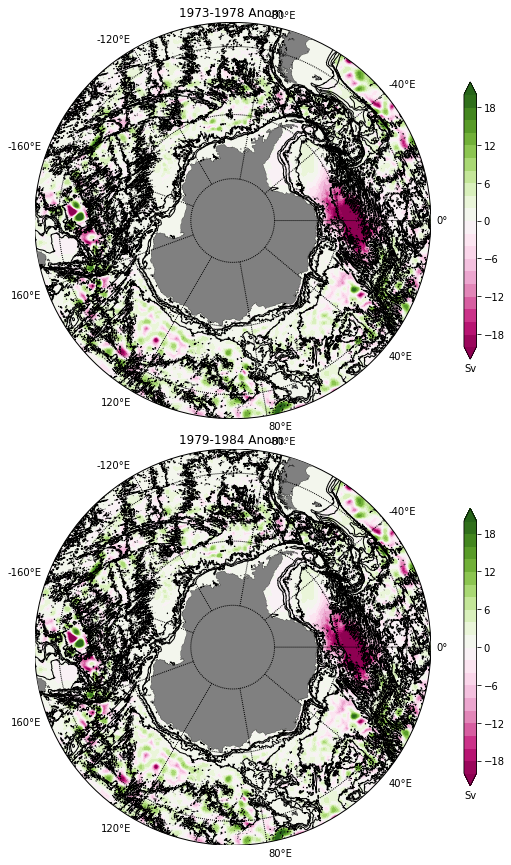

In [71]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-20,20,21)

t1=3
t2=27

plt.subplot(2,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(pert_psi_ann[t1:t2],axis=0)-np.mean(cntrl_psi_ann[t1:t2],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#p1=map.contourf(X,Y,np.mean(pert_psi[0:5],axis=0)-np.mean(cntrl_psi[0:5],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
#map.contour(X,Y,np.mean(pert_psi[0:5],axis=0)-np.mean(cntrl_psi[0:5],axis=0),levels=clev,colors='k',linewidths=1)
clev3 = np.arange(1000,5001,1000)
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    
plt.title('1973-1978 Anom.')

#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#cb.ax.set_ylabel('Sv')

t1=3
t2=27

plt.subplot(2,1,2)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,np.mean(pert_psi_ann[t1:t2],axis=0)-np.mean(cntrl_psi_ann[t1:t2],axis=0), cmap=plt.cm.PiYG, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
#clev3 = np.arange(0,200,20)
#print clev3
#map.contour(X,Y,np.mean(pert_psi[4:7],axis=0)-np.mean(cntrl_psi[4:7],axis=0),levels=clev,colors='k',linewidths=1)
clev3 = np.arange(1000,5001,1000)
print clev3
map.contour(X,Y,ht[:,:],levels=clev3,colors='k',linewidths=1)    
plt.title('1979-1984 Anom.')

#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#cb.ax.set_ylabel('Sv')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'psi.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'psi_anom.png')
plt.savefig(of,dpi=220)

In [72]:
# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

[600] [2109] [2129]


In [ ]:
#plot Drake Passage time series

yrs=np.arange(1973,2016,1)
T=np.arange(50)
print T.shape


ts =pert.tx_trans.shape[0]
print ts
print pert_psi_ann.shape[0]
ts=7
#print yrs[yr].astype('S4')
#tit=yrs[yr].astype('S4')
#plt.title(yrs[yr])plt.title(yrs[yr])

# do ACC psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

cntrl_dp = cntrl_psi_ann[:,0:j1,i1:i2]
cntrl_dp_bar = np.mean(cntrl_dp,2)
cntrl_dp_ts = np.max(cntrl_dp_bar,1)

pert_dp = pert_psi_ann[:,0:j1,i1:i2]
pert_dp_bar = np.mean(pert_dp,2)
pert_dp_ts = np.max(pert_dp_bar,1)

plt.subplot(211)
plt.plot(yrs[0:ts],cntrl_dp_ts[0:ts],linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(yrs[0:ts],pert_dp_ts[0:ts],linestyle='-',color='g',label='Perturbed',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit=('Drake Passage Transport')
plt.title(tit)
plt.legend(fontsize=10)

# do Weddell Gyre psi min between lon 67-69S
i1=np.argwhere(xt_ocean<-60)
i2=np.argwhere(xt_ocean<15)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-62)
j1=j1[-1]

print j1, i1, i2

cntrl_wg = cntrl_psi_ann[:,0:j1,i1:i2]
#cntrl_wg_bar = np.mean(cntrl_wg,2)
cntrl_wg_ts = np.min(np.min(cntrl_wg,2),1)

pert_wg = pert_psi_ann[:,0:j1,i1:i2]
#pert_wg_bar = np.mean(pert_wg,2)
pert_wg_ts = np.min(np.min(pert_wg,2),1)

plt.subplot(212)
plt.plot(yrs[0:ts],cntrl_wg_ts[0:ts],linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(yrs[0:ts],pert_wg_ts[0:ts],linestyle='-',color='g',label='Perturbed',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit=('Weddell Gyre Transport')
plt.title(tit)
plt.legend(fontsize=10)

plt.tight_layout()

#of = os.path.join(NYFPertDir,'dp_ts.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'dp_ts.png')
plt.savefig(of,dpi=220)

In [7]:
#plot temp
print cntrl.temp.shape
print pert.temp.shape

(77, 75, 2700, 3600)
(78, 75, 2700, 3600)


In [89]:
print st_ocean[18]
print st_ocean[50]

55.2064019937
1453.38443981


[-2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6
 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2. ]
55.2064019937
0 4 [443 444 445 446]
3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]
15 19 [458 459 460 461]
19 23 [462 463 464 465]
23 27 [466 467 468 469]


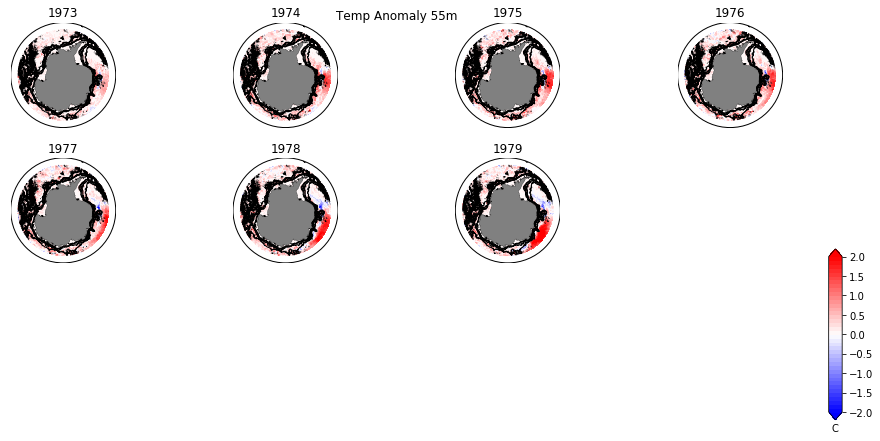

In [82]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Temp Anomaly 55m')
yrs=np.arange(1973,2016,1)

clev = np.linspace(-2,2,41)
print clev
st=18
print st_ocean[st]
ii=0

for yr in range(0,19):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
        
    print t1, t2, seasons[t1:t2]

    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    #map.drawparallels(np.arange(-80.,81.,15.))
    #map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
    
    p1=map.contourf(X,Y,pert.temp[t1:t2,st,0:500,:].mean('time').load()-cntrl.temp[t1:t2,st,0:500,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr].astype('S4'))

ax3 = plt.axes([0.98,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'temp_55m.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_55m.png')
plt.savefig(of,dpi=220)



[-0.5   -0.475 -0.45  -0.425 -0.4   -0.375 -0.35  -0.325 -0.3   -0.275
 -0.25  -0.225 -0.2   -0.175 -0.15  -0.125 -0.1   -0.075 -0.05  -0.025  0.
  0.025  0.05   0.075  0.1    0.125  0.15   0.175  0.2    0.225  0.25
  0.275  0.3    0.325  0.35   0.375  0.4    0.425  0.45   0.475  0.5  ]
1581.15373743
0 4 [443 444 445 446]
3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]
15 19 [458 459 460 461]
19 23 [462 463 464 465]
23 27 [466 467 468 469]


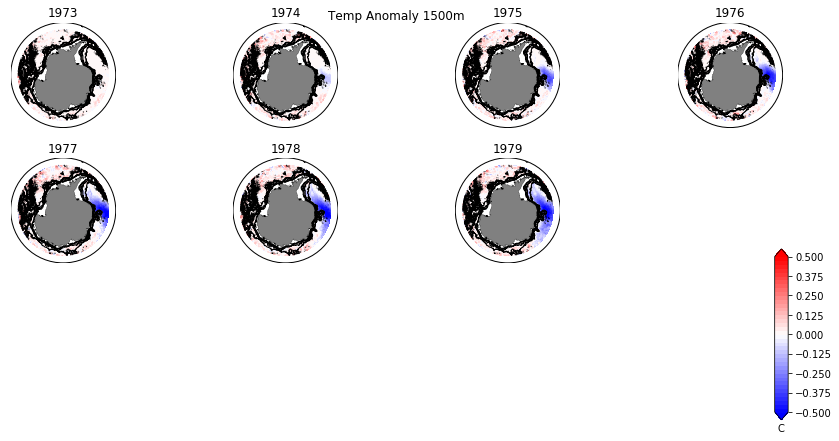

In [90]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Temp Anomaly 1500m')
yrs=np.arange(1973,2016,1)

clev = np.linspace(-.5,.5,41)
print clev
st=51
print st_ocean[st]
ii=0
for yr in range(0,7):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
        
    print t1, t2, seasons[t1:t2]
    #print yr

    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    #map.drawparallels(np.arange(-80.,81.,15.))
    #map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
    
    p1=map.contourf(X,Y,pert.temp[t1:t2,st,0:500,:].mean('time').load()-cntrl.temp[t1:t2,st,0:500,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    clev3 = np.arange(0,5000,1000)
    map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr].astype('S4'))

plt.tight_layout()

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

#of = os.path.join(NYFPertDir,'temp_1500m.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_1500m.png')
plt.savefig(of,dpi=220)



[ -3.00000000e-01  -2.90000000e-01  -2.80000000e-01  -2.70000000e-01
  -2.60000000e-01  -2.50000000e-01  -2.40000000e-01  -2.30000000e-01
  -2.20000000e-01  -2.10000000e-01  -2.00000000e-01  -1.90000000e-01
  -1.80000000e-01  -1.70000000e-01  -1.60000000e-01  -1.50000000e-01
  -1.40000000e-01  -1.30000000e-01  -1.20000000e-01  -1.10000000e-01
  -1.00000000e-01  -9.00000000e-02  -8.00000000e-02  -7.00000000e-02
  -6.00000000e-02  -5.00000000e-02  -4.00000000e-02  -3.00000000e-02
  -2.00000000e-02  -1.00000000e-02   2.77555756e-16   1.00000000e-02
   2.00000000e-02   3.00000000e-02   4.00000000e-02   5.00000000e-02
   6.00000000e-02   7.00000000e-02   8.00000000e-02   9.00000000e-02
   1.00000000e-01   1.10000000e-01   1.20000000e-01   1.30000000e-01
   1.40000000e-01   1.50000000e-01   1.60000000e-01   1.70000000e-01
   1.80000000e-01   1.90000000e-01   2.00000000e-01   2.10000000e-01
   2.20000000e-01   2.30000000e-01   2.40000000e-01   2.50000000e-01
   2.60000000e-01   2.70000000e-01

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


3 7 [446 447 448 449]
7 11 [450 451 452 453]
11 15 [454 455 456 457]
15 19 [458 459 460 461]
19 23 [462 463 464 465]
23 27 [466 467 468 469]
27 31 [470 471 472 473]
31 35 [474 475 476 477]
35 39 [478 479 480 481]
39 43 [482 483 484 485]
43 47 [486 487 488 489]
47 51 [490 491 492 493]
51 55 [494 495 496 497]
55 59 [498 499 500 501]
59 63 [502 503 504 505]
63 67 [506 507 508 509]
67 71 [510 511 512 513]
71 75 [514 515 516 517]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


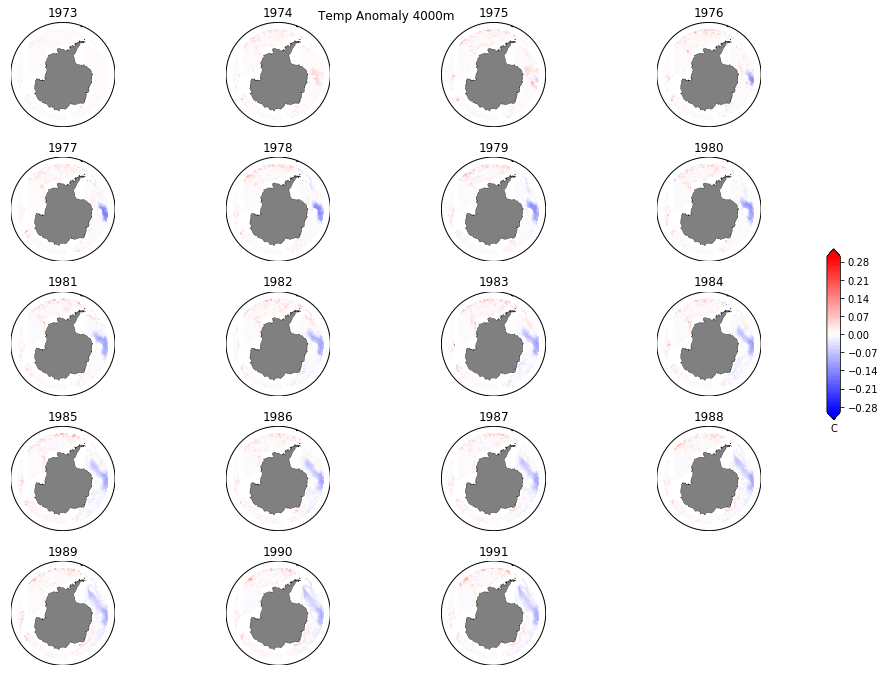

In [16]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Temp Anomaly 4000m')
yrs=np.arange(1973,2016,1)

clev = np.arange(-.2,.21,.01)
print clev
st=65
print st_ocean[st]
ii=0

for yr in range(0,19):
    #print yr
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
        
    print t1, t2, seasons[t1:t2]

    plt.subplot(5,4,yr+1)
    map = Basemap(projection='spstere',boundinglat=-55,lon_0=90,resolution='l',round=True)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    #map.drawparallels(np.arange(-80.,81.,15.))
    #map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
    X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
    
    p1=map.contourf(X,Y,pert.temp[t1:t2,st,0:2000,:].mean('time').load()-cntrl.temp[t1:t2,st,0:2000,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
    
    #cb=plt.colorbar(orientation='vertical',shrink = 0.5)
    #cb.ax.set_xlabel('N/m2')
    #clev3 = np.arange(0,5000,1000)
    #map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
    plt.title(yrs[yr].astype('S4'))

ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'temp_4000m.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'temp_4000m.png')
plt.savefig(of,dpi=220)


In [92]:
print st_ocean[65]

3946.16599027


In [ ]:
#store annual mean psi (instead of seasonal)
pert_temp_ann=np.zeros((19,pert.tx_trans.shape[2],pert.tx_trans.shape[3]))
cntrl_temp_ann=np.zeros((19,pert.tx_trans.shape[2],pert.tx_trans.shape[3]))

for yr in range(0,19):
    if yr<1:
        #first year is only 9 months ... use first 3 months of next year
        t1=0
        t2=4
    elif yr<2:
        t1=3
        t2=7
    else:
        t1=t2
        t2=t2+4
    
    print seasons[t1:t2]
    
    pert_temp_ann[yr,:,:]=np.mean(pert_psi[t1:t2,:,:],axis=0)
    cntrl_temp_ann[yr,:,:]=np.mean(cntrl_psi[t1:t2,:,:],axis=0)

In [13]:
#print yrs
#print yrs[1:8]
#print yrs[8:18]
#print yrs[18:29]

print st_ocean[54]

2006.97519805


[ -1.50000000e-01  -1.40000000e-01  -1.30000000e-01  -1.20000000e-01
  -1.10000000e-01  -1.00000000e-01  -9.00000000e-02  -8.00000000e-02
  -7.00000000e-02  -6.00000000e-02  -5.00000000e-02  -4.00000000e-02
  -3.00000000e-02  -2.00000000e-02  -1.00000000e-02   1.38777878e-16
   1.00000000e-02   2.00000000e-02   3.00000000e-02   4.00000000e-02
   5.00000000e-02   6.00000000e-02   7.00000000e-02   8.00000000e-02
   9.00000000e-02   1.00000000e-01   1.10000000e-01   1.20000000e-01
   1.30000000e-01   1.40000000e-01   1.50000000e-01]
2006.97519805
4526.90264999


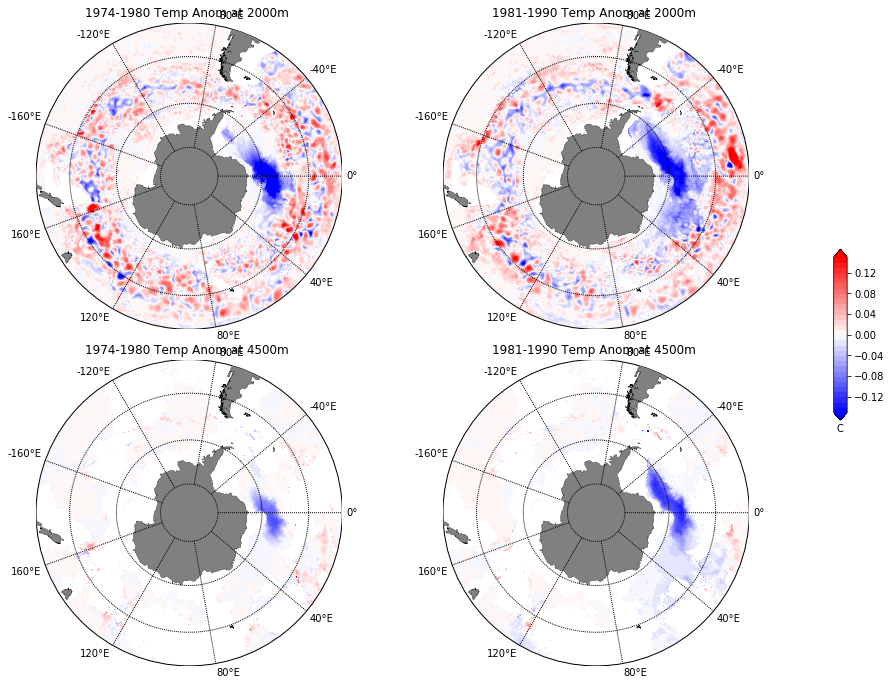

In [14]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-.15,.16,.01)
print clev


st=54
print st_ocean[st]

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:2000,:],geolat_t[0:2000,:]) 
p1=map.contourf(X,Y,pert.temp[3:31,st,0:2000,:].mean('time').load()-cntrl.temp[3:31,st,0:2000,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:2000,:],levels=clev3,colors='k',linewidths=1)
plt.title('1974-1980 Temp Anom at 2000m ')

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:2000,:],geolat_t[0:2000,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,pert.temp[31:71,st,0:2000,:].mean('time').load()-cntrl.temp[31:71,st,0:2000,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:2000,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-1990 Temp Anom at 2000m ')


st=68
print st_ocean[st]

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:2000,:],geolat_t[0:2000,:]) 
p1=map.contourf(X,Y,pert.temp[3:31,st,0:2000,:].mean('time').load()-cntrl.temp[3:31,st,0:2000,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:2000,:],levels=clev3,colors='k',linewidths=1)
plt.title('1974-1980 Temp Anom at 4500m ')

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:2000,:],geolat_t[0:2000,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,pert.temp[31:71,st,0:2000,:].mean('time').load()-cntrl.temp[31:71,st,0:2000,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:2000,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-1990 Temp Anom at 4500m ')

#plt.subplot(1,3,3)
#map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
#map.drawcoastlines(linewidth=0.25)
#map.fillcontinents(color='gray',lake_color='gray')
## draw parallels and meridians.
#map.drawparallels(np.arange(-80.,81.,15.))
##map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
#X, Y = map(geolon_t[0:2000,:],geolat_t[0:2000,:]) 
##cntrl starts 1971, pert in 1973.
##cntrl Tdim ends in 1980, normal starts 1981
#p1=map.contourf(X,Y,pert.temp[71:111,st,0:2000,:].mean('time').load()-cntrl.temp[71:111,st,0:2000,:].mean('time').load(), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
##cb=plt.colorbar(orientation='vertical',shrink = 0.5)
##cb.ax.set_xlabel('C')
##clev3 = np.arange(1000,5001,1000)
##map.contour(X,Y,ht[0:2000,:],levels=clev3,colors='k',linewidths=1)
#plt.title('1991-2000 Temp Anom at 4500m ')

ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#ax3 = plt.axes([0.92,0.38,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('C')

In [ ]:

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('(1991-2000)-(1981-1990) Decadal Temp Anom')
clev = np.arange(-.2,.21,.01)
#print clev

st=30
print st_ocean[30]

var1=pert.temp[8:18,st,0:500,:].mean('Time').load()-cntrl.temp[8+3:18+3,st,0:500,:].mean('Time').load()
var2=pert.temp[18:28,st,0:500,:].mean('Time').load()-cntrl.temp[18+3:28+3,st,0:500,:].mean('Time').load()

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,var2-var1, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1500m ')


st=35
print st_ocean[st]
var1=pert.temp[8:18,st,0:500,:].mean('Time').load()-cntrl.temp[8+3:18+3,st,0:500,:].mean('Time').load()
var2=pert.temp[18:28,st,0:500,:].mean('Time').load()-cntrl.temp[18+3:28+3,st,0:500,:].mean('Time').load()

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,var2-var1,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('2500m ')

st=40
print st_ocean[st]
var1=pert.temp[8:18,st,0:500,:].mean('Time').load()-cntrl.temp[8+3:18+3,st,0:500,:].mean('Time').load()
var2=pert.temp[18:28,st,0:500,:].mean('Time').load()-cntrl.temp[18+3:28+30,st,0:500,:].mean('Time').load()

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,var2-var1,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('3500m ')

st=45
print st_ocean[st]
var1=pert.temp[8:18,st,0:500,:].mean('Time').load()-cntrl.temp[8+3:18+3,st,0:500,:].mean('Time').load()
var2=pert.temp[18:28,st,0:500,:].mean('Time').load()-cntrl.temp[18+3:28+3,st,0:500,:].mean('Time').load()

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,var2-var1,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('4500m ')

ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

plt.tight_layout()

#ax3 = plt.axes([0.92,0.38,0.015,0.25])

In [ ]:
#calc zonal average temp anomalies
#Plot zonal average temp anomaly across weddell
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2

#print xt_ocean[x1:x2]
#print yt_ocean[:y1]

In [ ]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('Zonal Average Temp Anom 40W-15E')
#print cntrl.temp.shape
#print pert.temp.shape

#plt.subplot(211)
#clev = np.arange(-2,20,1)
#plt.contourf(yt_ocean[0:500],st_ocean,np.mean(cntrl_temp[:,:,x1:x2],axis=2),cmap=plt.cm.PiYG,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('Temp')
#plt.contour(yt_ocean[0:500],st_ocean,np.mean(cntrl_temp[:,:,x1:x2],axis=2),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,np.mean(cntrl_temp[:,:,x1:x2],axis=2),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
##plt.gca().yaxis.set_major_formatter(x_formatter)
##plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
#plt.xlim([-75,-50])
#plt.title('Control Temp')

yrs=np.arange(1973,2016,1)

ii=0
for yr in range(0,30):
    #print yr

    plt.subplot(6,5,yr+1)
    plt.gca().patch.set_color('.25')
    clev = np.arange(-.7,.71,0.1)
    
    p1=plt.contourf(yt_ocean[0:500],st_ocean,pert.temp[yr,:,0:500,x1:x2].mean('xt_ocean').load()-cntrl.temp[yr+3,:,0:500,x1:x2].mean('xt_ocean').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
        
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('kg/m3')
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    #plt.ylim((1037.5,1034))
    #plt.ylabel('Depth (m)')
    #plt.xlabel('Latitude ($^\circ$S)')
    plt.xlim([-75,-50])
    plt.title(yrs[yr])
    #plt.title('40W to 15E Temp Anomaly 1976')

ax3 = plt.axes([0.99,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

#plt.subplot(224)
#plt.gca().patch.set_color('.25')
#clev = np.arange(-.5,.51,0.1)
#plt.contourf(yt_ocean[0:500],st_ocean,np.mean(pert_temp[9,:,:,:],axis=2)-np.mean(cntrl_temp[:,:,:],axis=2),cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.title('180W to 180E Temp Anomaly 1982')

plt.tight_layout()

#of = os.path.join(NYFPertDir,'zavTanom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'zavgTanom.png')
plt.savefig(of,dpi=220)

In [ ]:
#store time-series between 60-65S and 40W-15E for hovmoeller
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
y2=np.argwhere(yt_ocean<-60)
y1=y1[-1]
y2=y2[-1]
print x1, x2
print y1, y2

#this is inaccurate ... area weight for yt_ocean
cTz=cntrl.temp[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print cTz.shape

pTz=pert.temp[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print pTz.shape

In [ ]:
#plot temp hovmoeller of depth vs time
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

time = np.arange(-1,20,1)
print time
print time.shape

yrs=np.arange(1972,2018,1)
print yrs.shape

print cTz[0,:].shape
var1=np.expand_dims(cTz[0,:], axis=0)
print var1.shape
var2 = np.concatenate((var1,pTz),axis=0)
print var2.shape

clev = np.arange(-1,1,.05)
#print clev

plt.subplot(211)
plt.contourf(yrs[0:45],st_ocean,var2.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Temp')

clev = np.arange(-.3,.31,.01)
#print clev


print pTz.shape, pTz.shape[0]
print cTz.shape

a=pTz-cTz[0:pTz.shape[0],:]
print a.shape


plt.subplot(212)
plt.contourf(yrs[0:41],st_ocean,a.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Temp Anom')

In [ ]:
#redo Purkey et al., 2018 figs 2: Temp trend mC/yr from 1981-2000 and 2000-2016. Assume linear trend.
#Southern Ocean and Global Ocean

#years is 1980-2020
#print cTemp.shape
print cntrl.temp.shape
#print pert.temp.shape

#area integrate over Southern Ocean and plot vertical profile of temp trend
y1=np.argwhere(yt_ocean<-60)
y2=np.argwhere(yt_ocean<-55)
y1=y1[-1]
y2=y2[-1]
print yt_ocean[y1], yt_ocean[y2]

#mask area_t for land cells.
msk=np.zeros((kmt.shape[0],kmt.shape[1]))
print msk.shape
msk[np.where(kmt>=1)]=1
area_t_mask=area_t*msk
print area_t_mask[:,500]

cTz=np.zeros((cntrl.temp.shape[0],cntrl.temp.shape[1]))
print cTz.shape

for t in range(cntrl.temp.shape[0]):
    print t
    
    for k in range(cntrl.temp.shape[1]):
        cTz[t,k]=np.ma.sum(cntrl.temp[t,k,0:y1,:].load()*area_t_mask[0:y1,:])
        cTz[t,k]=cTz[t,k]/np.ma.sum(area_t_mask[0:y1,:])
    
print cTz.shape
of=os.path.join(NYFCntrlDir,'cTz_Sof60S_1971-2020.npy')
a=np.save(of,cTz)

In [ ]:
#redo Purkey et al., 2018 figs 2: Temp trend mC/yr from 1981-2000 and 2000-2016. Assume linear trend.
#Southern Ocean and Global Ocean

#20 years is 1973-1993
#print cntrl.temp.shape
print pert.temp.shape

#area integrate over Southern Ocean and plot vertical profile of temp trend
y1=np.argwhere(yt_ocean<-60)
#y1=np.argwhere(yt_ocean<-55)
y1=y1[-1]

#mask area_t for land cells.
msk=np.zeros((kmt.shape[0],kmt.shape[1]))
print msk.shape
msk[np.where(kmt>=1)]=1
area_t_mask=area_t*msk
print area_t_mask[:,500]

pTz=np.zeros((pert.temp.shape[0],pert.temp.shape[1]))
print pTz.shape

for t in range(pert.temp.shape[0]):
    print t
    
    for k in range(pert.temp.shape[1]):
        pTz[t,k]=np.ma.sum(pert.temp[t,k,0:y1,:].load()*area_t_mask[0:y1,:])
        pTz[t,k]=pTz[t,k]/np.ma.sum(area_t_mask[0:y1,:])
    
print pTz.shape
print pTz[0,:]
print pTz[19,:]
of=os.path.join(NYFPertDir,'pTz_Sof60S.npy')
a=np.save(of,pTz)



In [ ]:
#just do Atlantic Sector
#mask area_t for land cells.
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<30)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-60)
#y1=np.argwhere(yt_ocean<-55)
y1=y1[-1]


msk=np.zeros((kmt.shape[0],kmt.shape[1]))
print msk.shape
msk[np.where(kmt>=1)]=1
area_t_mask=area_t*msk
print area_t_mask[:,500]

cAtlTz=np.zeros((cntrl.temp.shape[0],cntrl.temp.shape[1]))
print cAtlTz.shape

for t in range(cntrl.temp.shape[0]):
    print t
    
    for k in range(cntrl.temp.shape[1]):
        cAtlTz[t,k]=np.ma.sum(cntrl.temp[t,k,0:y1,x1:x2].load()*area_t_mask[0:y1,x1:x2])
        cAtlTz[t,k]=cAtlTz[t,k]/np.ma.sum(area_t_mask[0:y1,x1:x2])
    
print cAtlTz.shape
of=os.path.join(NYFCntrlDir,'cAtlTz_Sof60S_1971-2020.npy')
a=np.save(of,cAtlTz)



In [ ]:
#just do Atlantic Sector
#mask area_t for land cells.
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<30)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-60)
#y1=np.argwhere(yt_ocean<-55)
y1=y1[-1]


msk=np.zeros((kmt.shape[0],kmt.shape[1]))
print msk.shape
msk[np.where(kmt>=1)]=1
area_t_mask=area_t*msk
print area_t_mask[:,500]

pAtlTz=np.zeros((pert.temp.shape[0],pert.temp.shape[1]))
print pAtlTz.shape

for t in range(pert.temp.shape[0]):
    print t
    
    for k in range(pert.temp.shape[1]):
        pAtlTz[t,k]=np.ma.sum(pert.temp[t,k,0:y1,x1:x2].load()*area_t_mask[0:y1,x1:x2])
        pAtlTz[t,k]=pAtlTz[t,k]/np.ma.sum(area_t_mask[0:y1,x1:x2])
    
print pAtlTz.shape
print pAtlTz[0,:]
print pAtlTz[19,:]
of=os.path.join(NYFPertDir,'pAtlTz_Sof60S.npy')
a=np.save(of,pAtlTz)

In [ ]:
cyrs=arange(1970,2019,1)
pyrs=arange(1973,2016,1)
print cyrs.shape

print cyrs[3:11]
print pyrs[0:8]


print cyrs[11:31]
print pyrs[8:28]


print cyrs[31:47]
print pyrs[28:44]


In [ ]:
#Do southern ocean trend plot
of=os.path.join(NYFCntrlDir,'cTz_Sof60S_1971-2020.npy')
cTz=np.load(of)
print cTz.shape


of=os.path.join(NYFPertDir,'pTz_Sof60S.npy')
pTz=np.load(of)
print pTz.shape

cyrs=arange(1970,2020,1)
pyrs=arange(1973,2017,1)
print cyrs.shape
print cyrs[3:11]
print pyrs.shape
print pyrs[0:8]

#calc linear trend in mC/yr over whole period
print range(8)
tr_pTz=np.polyfit(range(8), pTz[0:8,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(8), cTz[3:11,:],1)
print tr_cTz.shape
print tr_cTz[0,:]


plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

plt.subplot(411)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
plt.xlim([-10,10])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='1973-1980 Linear Temp Trend South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

#calc linear trend in mC/yr since 1981-2000 (8 years from 1973) 
print cyrs[11:31]
print pyrs.shape
print pyrs[8:28]

print range(20)
tr_pTz=np.polyfit(range(20), pTz[8:28,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(20), cTz[8+3:28+3,:],1)
print tr_cTz.shape
print tr_cTz[0,:]

plt.subplot(412)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
plt.xlim([-2,2])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='1981-2000 Linear Temp Trend South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

#calc linear trend in mC/yr since 2001-2011 (8 years from 1973) 
print cyrs[31:50]
print pyrs[28:44]

tr_pTz=np.polyfit(range(16), pTz[28:44,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(16), cTz[31:47,:],1)
print tr_cTz.shape
print tr_cTz[0,:]

plt.subplot(413)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
plt.xlim([-2,2])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='2001-2017 Linear Temp Trend South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

#calc linear trend in mC/yr since 1981-2017 
print cyrs[3:41]
print pyrs[0:38]

tr_pTz=np.polyfit(range(36), pTz[8:44,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(36), cTz[3+8:44+3,:],1)
print tr_cTz.shape
print tr_cTz[0,:]

plt.subplot(414)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
plt.xlim([-2,2])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='1981-2017 Linear Temp Trend South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

plt.tight_layout()

#of = os.path.join(NYFPertDir,'gmoc_ts.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'tr_Tz.png')
plt.savefig(of,dpi=220)

In [ ]:

cyrs=arange(1970,2019,1)
pyrs=arange(1973,2016,1)
print cyrs.shape
print cyrs[3:11]
print pyrs.shape
print pyrs[0:8]


print cyrs[11:31]
print pyrs[8:28]


print cyrs[31:47]
print pyrs[28:44]


In [ ]:
#Do Atlantic sector of southern ocean trend plot

of=os.path.join(NYFCntrlDir,'cAtlTz_Sof60S_1971-2020.npy')
cAtlTz=np.load(of)
print cAtlTz.shape

of=os.path.join(NYFPertDir,'pAtlTz_Sof60S.npy')
pAtlTz=np.load(of)
print pAtlTz.shape


cyrs=arange(1970,2019,1)
pyrs=arange(1973,2016,1)
print cyrs.shape
print cyrs[3:11]
print pyrs.shape
print pyrs[0:8]

#calc linear trend in mC/yr over whole period
print range(8)
tr_pTz=np.polyfit(range(8), pAtlTz[0:8,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(8), cAtlTz[3:11,:],1)
print tr_cTz.shape
print tr_cTz[0,:]


plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

plt.subplot(411)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
#plt.xlim([-20,20])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='1973-1980 Linear Temp Trend Atlantic South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

#calc linear trend in mC/yr since 1981-2000 (8 years from 1973) 
print cyrs[11:31]
print pyrs.shape
print pyrs[8:28]

print range(20)
tr_pTz=np.polyfit(range(20), pAtlTz[8:28,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(20), cAtlTz[11:31,:],1)
print tr_cTz.shape
print tr_cTz[0,:]

plt.subplot(412)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
#plt.xlim([-5,5])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='1981-2000 Linear Temp Trend Atlantic South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

#calc linear trend in mC/yr since 2001-2017 (8 years from 1973) 
print cyrs[31:47]
print pyrs[28:44]

print range(16)
tr_pTz=np.polyfit(range(16), pAtlTz[28:44,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(16), cAtlTz[31:47,:],1)
print tr_cTz.shape
print tr_cTz[0,:]

plt.subplot(413)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
#plt.xlim([-5,5])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='2001-2017 Linear Temp Trend Atlantic South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

#calc linear trend in mC/yr since 1981-2017 
print cyrs[8+3:47]
print pyrs[8:44]

tr_pTz=np.polyfit(range(44-8), pAtlTz[8:44,:],1)
print tr_pTz.shape
print tr_pTz[0,:]

tr_cTz=np.polyfit(range(44-8), cAtlTz[8+3:47,:],1)
print tr_cTz.shape
print tr_cTz[0,:]

plt.subplot(414)
plt.plot(tr_cTz[0,:]*1000,st_ocean,linestyle='-',color='k',label='Control',linewidth=2)
plt.plot(tr_pTz[0,:]*1000,st_ocean,linestyle='-',color='g',label='Perturbation',linewidth=2)
plt.plot(tr_pTz[0,:]*1000-tr_cTz[0,:]*1000,st_ocean,linestyle='--',color='g',label='Perturbation-Control',linewidth=2)
#plt.xlim([-2,2])
plt.ylim([1000,5500])
plt.gca().invert_yaxis()
plt.xlabel('mC/yr')
plt.ylabel('Depth (m)')
tit='1981-2017 Linear Temp Trend Atlantic South of 60$^\circ$S'
plt.title(tit)
plt.legend(fontsize=10)

plt.tight_layout()

#of = os.path.join(NYFPertDir,'gmoc_ts.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'tr_AtlTz.png')
plt.savefig(of,dpi=220)

In [ ]:
#depth average between 2000-4000m and below 4000m, Fig 3 of Purkey et al., 2016.
#calculate linear ocean warming trends spanning 1981 to 2016
dst=np.zeros(50)
dst[1:50]=np.diff(st_ocean)
dst[0]=st_ocean[0]
print dst.shape

#depth integrate from 2000-4000 and 4000:
print st_ocean[33:43]
print st_ocean[43:50]



print pert.temp.shape
pT_2to4=np.zeros((pert.temp.shape[0],pert.temp.shape[2],pert.temp.shape[3]))
pT_4to6=np.zeros((pert.temp.shape[0],pert.temp.shape[2],pert.temp.shape[3]))
print pT_2to4.shape

for t in range(pert.temp.shape[0]):
    print t
    
    pT_2to4[t,:,:]=np.ma.sum(pert.temp[t,33:43,:,:].load()*dzt[33:43,:,:],axis=0)/np.ma.sum(dzt[33:43,:,:],axis=0)
    pT_4to6[t,:,:]=np.ma.sum(pert.temp[t,43:50,:,:].load()*dzt[43:50,:,:],axis=0)/np.ma.sum(dzt[43:50,:,:],axis=0)

    
print pT_2to4.shape
of=os.path.join(NYFPertDir,'pT_2to4.npy')
a=np.save(of,pT_2to4)

print pT_4to6.shape
of=os.path.join(NYFPertDir,'pT_4to6.npy')
a=np.save(of,pT_4to6)    

In [ ]:
#depth average between 2000-4000m and below 4000m, Fig 3 of Purkey et al., 2016.
#calculate linear ocean warming trends spanning 1981 to 2016

#depth integrate from 2000-4000 and 4000:
print st_ocean[33:43]
print st_ocean[43:50]

print cntrl.temp.shape
cT_2to4=np.zeros((50,cntrl.temp.shape[2],cntrl.temp.shape[3]))
cT_4to6=np.zeros((50,cntrl.temp.shape[2],cntrl.temp.shape[3]))
print cT_2to4.shape

for t in range(50):
    print t
    
    cT_2to4[t,:,:]=np.ma.sum(cntrl.temp[t,33:43,:,:].load()*dzt[33:43,:,:],axis=0)/np.ma.sum(dzt[33:43,:,:],axis=0)
    cT_4to6[t,:,:]=np.ma.sum(cntrl.temp[t,43:50,:,:].load()*dzt[43:50,:,:],axis=0)/np.ma.sum(dzt[43:50,:,:],axis=0)
    
print cT_2to4.shape
of=os.path.join(NYFCntrlDir,'cT_2to4.npy')
a=np.save(of,cT_2to4)

print cT_4to6.shape
of=os.path.join(NYFCntrlDir,'cT_4to6.npy')
a=np.save(of,cT_4to6)    

In [ ]:
of=os.path.join(NYFCntrlDir,'cT_2to4.npy')
cT_2to4=np.load(of)

of=os.path.join(NYFCntrlDir,'cT_4to6.npy')
cT_4to6=np.load(of)  

print cT_2to4.shape
print cT_4to6.shape

of=os.path.join(NYFPertDir,'pT_2to4.npy')
pT_2to4=np.load(of)

of=os.path.join(NYFPertDir,'pT_4to6.npy')
pT_4to6=np.load(of)  

print pT_2to4.shape
print pT_4to6.shape


In [ ]:
cyrs=arange(1970,2019,1)
pyrs=arange(1973,2016,1)
print cyrs.shape
print cyrs[3:11]
print pyrs.shape
print pyrs[0:8]


print cyrs[11:21]
print cyrs[21:31]
print pyrs[8:18]
print pyrs[18:28]

In [ ]:

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.suptitle('(1991-2000)-(1981-1990) Decadal Temp Anom')

clev = np.arange(-.15,.16,.01)
#print clev
print cyrs[11:21]
print cyrs[21:31]
print pyrs[8:18]
print pyrs[18:28]


var1=np.mean(cT_2to4[11:21,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()
var2=np.mean(cT_2to4[21:31,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()
var3=np.mean(pT_2to4[8:18,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()
var4=np.mean(pT_2to4[18:28,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,(var4-var2)-(var3-var1), cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('2000-4000m ')

ax3 = plt.axes([0.99,0.68,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('C')

clev = np.arange(-.15,.16,.01)

var1=np.mean(cT_4to6[11:21,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()
var2=np.mean(cT_4to6[21:31,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()
var3=np.mean(pT_4to6[8:18,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()
var4=np.mean(pT_4to6[18:28,0:500,:],axis=0) #-cntrl2.temp[0:10,st,0:500,:].mean('Time').load()

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,(var4-var2)-(var3-var1),cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
#cb=plt.colorbar(orientation='vertical',shrink = 0.5)
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('4000-5500m')

plt.tight_layout()

of = os.path.join(NYFPertDir,'Tanom_decadal.png')
plt.savefig(of,dpi=220)

#ax3 = plt.axes([0.92,0.38,0.015,0.25])

In [ ]:
#convert dT/dt to W/m2=J/s/m2
#dT/dt=K/s
#W=J/s
#Cp=3985 J/kg/K

#dT/dt*Cp = J/s/kg*rho_0 = J/s/m3 *layer thickness?

#calc dT/dt
cyrs=np.arange(1971,2017,1)
pyrs=np.arange(1973,2017,1)

#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
print cyrs[11:31]
print pyrs[8:28]
print pyrs[18:28]

tr81to00_pT_2to4=np.zeros((500,1440))
tr81to00_cT_2to4=np.zeros((500,1440))
tr81to00_pT_4to6=np.zeros((500,1440))
tr81to00_cT_4to6=np.zeros((500,1440))

tr00to17_pT_2to4=np.zeros((500,1440))
tr00to17_cT_2to4=np.zeros((500,1440))
tr00to17_pT_4to6=np.zeros((500,1440))
tr00to17_cT_4to6=np.zeros((500,1440))

tr81to17_pT_2to4=np.zeros((500,1440))
tr81to17_cT_2to4=np.zeros((500,1440))
tr81to17_pT_4to6=np.zeros((500,1440))
tr81to17_cT_4to6=np.zeros((500,1440))


for j in range(0,500):
    #print j
    
    tr81to00_pT_2to4[j,:]=np.polyfit(range(20), pT_2to4[8:28,j,:],1)[0,:]
    tr81to00_cT_2to4[j,:]=np.polyfit(range(20), cT_2to4[11:31,j,:],1)[0,:]
    
    tr00to17_pT_2to4[j,:]=np.polyfit(range(16), pT_2to4[28:44,j,:],1)[0,:]
    tr00to17_cT_2to4[j,:]=np.polyfit(range(16), cT_2to4[31:47,j,:],1)[0,:]
    
    tr81to17_pT_2to4[j,:]=np.polyfit(range(36), pT_2to4[8:44,j,:],1)[0,:]
    tr81to17_cT_2to4[j,:]=np.polyfit(range(36), cT_2to4[11:47,j,:],1)[0,:]

    tr81to00_pT_4to6[j,:]=np.polyfit(range(20), pT_4to6[8:28,j,:],1)[0,:]
    tr81to00_cT_4to6[j,:]=np.polyfit(range(20), cT_4to6[11:31,j,:],1)[0,:]    
    
    tr00to17_pT_4to6[j,:]=np.polyfit(range(16), pT_4to6[28:44,j,:],1)[0,:]
    tr00to17_cT_4to6[j,:]=np.polyfit(range(16), cT_4to6[31:47,j,:],1)[0,:]

    tr81to17_pT_4to6[j,:]=np.polyfit(range(36), pT_4to6[8:44,j,:],1)[0,:]
    tr81to17_cT_4to6[j,:]=np.polyfit(range(36), cT_4to6[11:47,j,:],1)[0,:]

#Cp=3985 J/kg/K
#dT/dt*Cp = J/s/kg*rho_0 = J/s/m3 *layer thickness?
s_yr=365*24*60*60
Cp=3985
rho0=1034
#print s_yr
#print np.ma.sum(dzt[33:43,500,500],axis=0)
#print np.ma.sum(dzt[43:50,500,500],axis=0)
#print pert.temp[0,43:50,500,500].load()
#print dzt[43:50,500,500]

#W/m2=K/yr*yr/s*J/kg/K*kg/m3*m
#J/s/m2=W/m2
tr81to00_pT_2to4_wm2=tr81to00_pT_2to4/s_yr*Cp*1034*np.ma.sum(dzt[33:43,0:500,:],axis=0)
tr81to00_cT_2to4_wm2=tr81to00_cT_2to4/s_yr*Cp*1034*np.ma.sum(dzt[33:43,0:500,:],axis=0)
tr00to17_pT_2to4_wm2=tr81to00_pT_2to4/s_yr*Cp*1034*np.ma.sum(dzt[33:43,0:500,:],axis=0)
tr00to17_cT_2to4_wm2=tr81to00_cT_2to4/s_yr*Cp*1034*np.ma.sum(dzt[33:43,0:500,:],axis=0)
tr81to17_pT_2to4_wm2=tr81to00_pT_2to4/s_yr*Cp*1034*np.ma.sum(dzt[33:43,0:500,:],axis=0)
tr81to17_cT_2to4_wm2=tr81to00_cT_2to4/s_yr*Cp*1034*np.ma.sum(dzt[33:43,0:500,:],axis=0)

tr81to00_pT_4to6_wm2=tr81to00_pT_4to6/s_yr*Cp*1034*np.ma.sum(dzt[43:50,0:500,:],axis=0)
tr81to00_cT_4to6_wm2=tr81to00_cT_4to6/s_yr*Cp*1034*np.ma.sum(dzt[43:50,0:500,:],axis=0)
tr00to17_pT_4to6_wm2=tr81to00_pT_4to6/s_yr*Cp*1034*np.ma.sum(dzt[43:50,0:500,:],axis=0)
tr00to17_cT_4to6_wm2=tr81to00_cT_4to6/s_yr*Cp*1034*np.ma.sum(dzt[43:50,0:500,:],axis=0)
tr81to17_pT_4to6_wm2=tr81to00_pT_4to6/s_yr*Cp*1034*np.ma.sum(dzt[43:50,0:500,:],axis=0)
tr81to17_cT_4to6_wm2=tr81to00_cT_4to6/s_yr*Cp*1034*np.ma.sum(dzt[43:50,0:500,:],axis=0)

print tr81to00_pT_2to4_wm2.shape
    

In [ ]:
#plot dT/dt K/yr heating trend
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('(1991-2000)-(1981-1990) Decadal Temp Anom')

clev = np.arange(-.01,.01,.001)
#print clev

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr81to00_pT_2to4-tr81to00_cT_2to4, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('C/yr')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 2000-4000m ')

#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')

clev = np.arange(-.01,.01,.001)

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr81to00_pT_4to6-tr81to00_cT_4to6,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('C/yr')
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 4000-5500m')


clev = np.arange(-.01,.01,.001)
#print clev

plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr00to17_pT_2to4-tr00to17_cT_2to4, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('C/yr')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('2001-2010 2000-4000m ')

#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')

clev = np.arange(-.01,.01,.001)

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr00to17_pT_4to6-tr00to17_cT_4to6,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('C/yr')
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('2001-2010 4000-5500m')
          
#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
##ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')

plt.tight_layout()


of = os.path.join(NYFPertDir,'Tanom_Trend_XY.png')
plt.savefig(of,dpi=220)

#ax3 = plt.axes([0.92,0.38,0.015,0.25])

In [ ]:
#plot W/m2 heating trend
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('(1991-2000)-(1981-1990) Decadal Temp Anom')

clev = np.arange(-2,2,.01)
#print clev

plt.subplot(2,2,1)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr81to00_pT_2to4_wm2-tr81to00_cT_2to4_wm2, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('$W/m^2$')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 2000-4000m ')

#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')

clev = np.arange(-1,1,.01)

plt.subplot(2,2,2)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr81to00_pT_4to6_wm2-tr81to00_cT_4to6_wm2,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('$W/m^2$')
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 4000-5500m')


plt.subplot(2,2,3)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr00to17_pT_2to4_wm2-tr00to17_cT_2to4_wm2, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('$W/m^2$')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('2001-2010 2000-4000m ')

#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')

clev = np.arange(-1,1,.01)

plt.subplot(2,2,4)
map = Basemap(projection='spstere',boundinglat=-40,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t[0:500,:],geolat_t[0:500,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,tr00to17_pT_4to6_wm2-tr00to17_cT_4to6_wm2,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('$W/m^2$')
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('2001-2010 4000-5500m')

#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
##ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')

plt.tight_layout()
of = os.path.join(NYFPertDir,'Heating_Trend_XY.png')
plt.savefig(of,dpi=220)
#ax3 = plt.axes([0.92,0.38,0.015,0.25])

In [ ]:
#do salinity now

In [ ]:
var2=cntrl.pot_rho_0[:,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()

ii=0
for yr in range(0,numyrs):
    #print yr
    var1=pert.pot_rho_0[yr,:,0:500,x1:x2].mean('xt_ocean').load()
    #print var1.shape, var2.shape
    
    plt.subplot(4,5,yr+1)
    plt.gca().patch.set_color('.25')
    clev = np.linspace(-.01,.01,21)
    
    p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-var2,cmap=plt.cm.PiYG,levels=clev,extend='both')
    #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
    #cb.ax.set_xlabel('kg/m3')
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
    #plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
    plt.gca().invert_yaxis()
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    #plt.ylim((1037.5,1034))
    #plt.ylabel('Depth (m)')
    #plt.xlabel('Latitude ($^\circ$S)')
    plt.xlim([-75,-50])
    plt.title(yrs[yr])
    #plt.title('40W to 15E Temp Anomaly 1976')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('kg/m3')

#plt.subplot(224)
#plt.gca().patch.set_color('.25')
#clev = np.arange(-.5,.51,0.1)
#plt.contourf(yt_ocean[0:500],st_ocean,np.mean(pert_temp[9,:,:,:],axis=2)-np.mean(cntrl_temp[:,:,:],axis=2),cmap=plt.cm.PiYG,levels=clev,extend='both')
#plt.title('180W to 180E Temp Anomaly 1982')

#of = os.path.join(NYFPertDir,'zavTanom.pdf')
#print of
#plt.savefig(of)
of = os.path.join(NYFPertDir,'zavRhoanom.png')
plt.savefig(of,dpi=220)

In [ ]:
#store time-series between 60-65S at different depths
#pTz=np.zeros(pert_temp.shape[0],pert_temp.shape[1])
#cTz=np.zeros(pert_temp.shape[0],pert_temp.shape[1])
#print pTz.shape

x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
y2=np.argwhere(yt_ocean<-60)
y1=y1[-1]
y2=y2[-1]
print x1, x2
print y1, y2

#cntrl_ztemp=ff.temp[0:5,:,0:500,859:1279].mean('time').mean('xt_ocean').load()
#need to area average this ...
cTz=cntrl.pot_rho_0[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print cTz.shape

#pert_ztemp=ff.temp[0:5,:,0:500,859:1279].mean('time').mean('xt_ocean').load()
#print pert_ztemp.shape

pTz=pert.pot_rho_0[:,:,y1:y2,x1:x2].mean('yt_ocean').mean('xt_ocean').load()
print pTz.shape

In [ ]:
#plot rho hovmoeller of depth vs time
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

time = np.arange(-1,20,1)
print time
print time.shape

yrs=np.arange(1972,2016,1)

print cTz[0,:].shape
cn1=np.expand_dims(cTz[0,:], axis=0)
print cn1.shape
cn = np.concatenate((cn1,pTz),axis=0)
print cn.shape

clev = np.linspace(1027.7,1027.8,51)
#print clev

plt.subplot(211)
plt.contourf(yrs[0:numyrs+1],st_ocean,cn.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('kg/m3')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Rho')

clev = np.linspace(-.01,.01,21)
#print clev

time = np.arange(0,20,1)
print time
print time.shape
print pTz.shape
a=pTz-np.mean(cTz,axis=0)
print a.shape


plt.subplot(212)
plt.contourf(yrs[0:numyrs],st_ocean,a.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('kg/m3')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m')
plt.xlabel('Years')
#plt.xlim([-75,85])
plt.title('60-65S and 40W-15E Rho Anom')

In [ ]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
x1=np.argwhere(xt_ocean<-40)
x2=np.argwhere(xt_ocean<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(yt_ocean<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2

In [ ]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.title('Control Zavg Tracers 40W-15E')

yr=0
var1=cntrl.pot_rho_0[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(1027.7,1027.8,51)

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Rho')

var1=cntrl.temp[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(-2,2,51)

plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Temp')

var1=cntrl.salt[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(34,35,51)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Salt')



In [ ]:
#compare tracers to WOA13
#Ocean_File = '/g/data1/v45/pas561/mom/archive/woa13_mom025_ocean_temp_salt.res.nc'
#print Ocean_File
#woa=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print woa.temp.shape

nc = Dataset('/g/data1/v45/pas561/mom/archive/woa13_mom025_ocean_temp_salt.res.nc', mode='r') # file handle, open in read only mode
grid_xt = nc.variables['GRID_X_T'][:]
grid_yt = nc.variables['GRID_Y_T'][:]
zt = nc.variables['ZT'][:]
woa_temp = nc.variables['temp'][:]
woa_salt = nc.variables['salt'][:]
nc.close() # close the file

print woa_salt.shape, woa_temp.shape, grid_xt.shape, grid_yt.shape, zt.shape

woa_temp=np.squeeze(woa_temp)
woa_salt=np.squeeze(woa_salt)

print woa_salt.shape, woa_temp.shape


In [ ]:
#mask bathy 
#msk=ma.getmask(cntrl.temp[0].load())
msk=cntrl.temp[0].load()
print msk[:,500,500]
print woa_temp[:,500,500]


woa_temp[np.where(isnan(msk))]=nan
print woa_temp[:,500,500]
woa_salt[np.where(isnan(msk))]=nan
print woa_salt[:,500,500]

#woaT=numpy.ma.fix_invalid()
#msk[np.where(msk<-1)]=0
#msk[np.where(msk==-1)]=1


In [ ]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
x1=np.argwhere(grid_xt<-40)
x2=np.argwhere(grid_xt<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(grid_yt<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]



In [ ]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.title('WOA13 Zavg Tracers 40W-15E')

yr=0
var1=np.nanmean(woa_temp[:,0:500,x1:x2],axis=2)

clev = np.linspace(1027.7,1027.8,51)

plt.subplot(3,2,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('WOA13 Rho')

yr=0

var1=cntrl.pot_rho_0[yr,:,0:500,x1:x2].mean('xt_ocean').load()

plt.subplot(3,2,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Rho')


var1=np.nanmean(woa_temp[:,0:500,x1:x2],axis=2)

clev = np.linspace(-2,2,51)

plt.subplot(3,2,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('WOA13 Temp')

var1=cntrl.temp[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(-2,2,51)

plt.subplot(3,2,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('C')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Temp')

var1=np.nanmean(woa_salt[:,0:500,x1:x2],axis=2)

clev = np.linspace(34,35,51)

plt.subplot(3,2,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('WOA13 Salt')

var1=cntrl.salt[yr,:,0:500,x1:x2].mean('xt_ocean').load()

clev = np.linspace(34,35,51)

plt.subplot(3,2,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sa')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('Control Salt')


In [ ]:
#stop current analysis here
## Calc the AMOC from ty_trans for forcing cases

In [ ]:


#calculate the AMOC mask
#-1 is Atl and Arctic, all other ocean is -2, land is 0
#reset to 1 and 0
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0
msk[np.where(msk==-1)]=1

clev = np.arange(-2,2,1)
print clev

plt.subplot(211)
plt.contourf(geolon_t,geolat_t,msk,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Mask')
plt.title('AMOC Mask')

In [ ]:
#do AMOC in zspace
Ocean_File = os.path.join(NYFCntrlDir,'output5*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape

#tt=ff.ty_trans[1,:,500,500].load()
#print 'no mask', tt

ty=ff.ty_trans*msk
print ty.shape
#tt=ty[1,:,500,500].load()
#print 'mask',tt

cntrl_amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()

of=os.path.join(NYFCntrlDir,'amoc_z.npy')
a=np.save(of,cntrl_amoc)

In [ ]:
#do AMOC in zspace
Ocean_File = os.path.join(NYFPertDir,'output5*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape

#tt=ff.ty_trans[1,:,500,500].load()
#print 'no mask', tt

ty=ff.ty_trans*msk
print ty.shape
#tt=ty[1,:,500,500].load()
#print 'mask',tt

pert_amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()

of=os.path.join(NYFPertDir,'amoc_z.npy')
a=np.save(of,pert_amoc)

In [ ]:
of=os.path.join(NYFPertDir,'amoc_z.npy')
pert_amoc=np.load(of)
print pert_amoc.shape

of=os.path.join(NYFCntrlDir,'amoc_z.npy')
cntrl_amoc=np.load(of)
print cntrl_amoc.shape


In [ ]:
#Amoc in Z space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

plt.subplot(221)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_amoc,axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc,axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc,axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Control Amoc'
plt.title(tit)

t1=0
t2=5

plt.subplot(222)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Perturbed AMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=0
t2=5

clev = np.arange(-5,6,.5)

plt.subplot(223)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=6
t2=10

plt.subplot(224)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc,axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc,axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc,axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)


In [ ]:
#plot time series of AMOC in z space
T=np.arange(14)
print T.shape


# do lower cell average between lats 55-60N
j1=np.argwhere(yt_ocean<55)
j2=np.argwhere(yt_ocean<60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(st_ocean<500)
z1=z1[-1]

uc_cntrl50_psj = cntrl_amoc[:,z1:,j1:j2]
uc_cntrl50_psj_bar = np.mean(uc_cntrl50_psj,2)
uc_cntrl50_psj_ts = np.max(uc_cntrl50_psj_bar,1)

uc_pert50_psj = pert_amoc[:,z1:,j1:j2]
uc_pert50_psj_bar = np.mean(uc_pert50_psj,2)
uc_pert50_psj_ts = np.max(uc_pert50_psj_bar,1)
uc_pert50_psj_ts=np.insert(uc_pert50_psj_ts,0,uc_cntrl50_psj_ts[0])


# do lower cell average between lats 40-45N
j1=np.argwhere(yt_ocean<30)
j2=np.argwhere(yt_ocean<35)
j1=j1[-1]
j2=j2[-1]

uc_cntrl40_psj = cntrl_amoc[:,z1:,j1:j2]
uc_cntrl40_psj_bar = np.mean(uc_cntrl40_psj,2)
uc_cntrl40_psj_ts = np.max(uc_cntrl40_psj_bar,1)

uc_pert40_psj = pert_amoc[:,z1:,j1:j2]
uc_pert40_psj_bar = np.mean(uc_pert40_psj,2)
uc_pert40_psj_ts = np.max(uc_pert40_psj_bar,1)
uc_pert40_psj_ts=np.insert(uc_pert40_psj_ts,0,uc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25N
j1=np.argwhere(yt_ocean<10)
j2=np.argwhere(yt_ocean<15)
j1=j1[-1]
j2=j2[-1]

uc_cntrl20_psj = cntrl_amoc[:,z1:,j1:j2]
uc_cntrl20_psj_bar = np.mean(uc_cntrl20_psj,2)
uc_cntrl20_psj_ts = np.max(uc_cntrl20_psj_bar,1)

uc_pert20_psj = pert_amoc[:,z1:,j1:j2]
uc_pert20_psj_bar = np.mean(uc_pert20_psj,2)
uc_pert20_psj_ts = np.max(uc_pert20_psj_bar,1)
uc_pert20_psj_ts=np.insert(uc_pert20_psj_ts,0,uc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(uc_pert50_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(uc_cntrl50_psj_ts,linestyle='-',color='k',label='55-60$^\circ$N',linewidth=2)
plt.plot(uc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(uc_cntrl40_psj_ts,linestyle='--',color='k',label='30-35$^\circ$N',linewidth=2)
plt.plot(uc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(uc_cntrl20_psj_ts,linestyle=':',color='k',label='10-15$^\circ$N',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='AMOC Upper Cell Z > ' +str(st_ocean[z1])
plt.title(tit)
plt.legend(fontsize=10)

In [ ]:
print np.max(fh[540:1080,:])
print np.min(fh[540:1080,:])

In [ ]:
#Hov of Sea Ice Conc. in Southern Ocean
print xt_ocean[1040]
print xt_ocean[878]

Ocean_File = os.path.join(CntrlDir,'output5*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print nyf_cn.shape

Ocean_File = os.path.join(PertDir,'output*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
pert_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print pert_cn.shape


In [ ]:
print nyf_cn.shape
print pert_cn.shape
cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
print cn.shape

time = np.arange(-12,192,1)
#print time
print time.shape

print xt_ocean[1040]
print xt_ocean[878]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(0,1.0,11)
print clev

plt.subplot(211)
plt.contourf(time,yt_ocean,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('Strong/Shift Weddell Sea Sea Ice Concentration')